In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from ast import literal_eval
from matplotlib_venn import venn2

sns.set_style("whitegrid")

In [2]:
# Okabe-Ito color palette
okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # light blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # dark blue
    "#D55E00",  # red
    "#CC79A7",  # pink
    "#000000",  # black
]

# Use the palette in matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=okabe_ito_colors)

# Use the palette in seaborn
sns.set_palette(okabe_ito_colors)

# Use the palette in pandas
pd.options.plotting.matplotlib.register_converters = False
pd.plotting.register_matplotlib_converters()
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=okabe_ito_colors)

Meta spacers -> spacers in metagenomic datasets to defend against the plasmids from our dataset

Query: a plasmid or a virus

spacer_hit: a spacer from metagenomes

## CRISPRs in plasmids (cctyper)

In [3]:
ptus = pd.read_csv(
    "../ptu_derep/derep_plasmids_clusters_with_ptu_ids.tsv",
    sep="\t",
    index_col=0,
    header=None,
)

ptus_mapping = {}
for ptu in ptus.index:
    for plasmid in ptus.loc[ptu, 2].split(","):
        ptus_mapping[plasmid] = ptu

In [4]:
df_env = pd.read_csv("../env_corr/taxon_countries.tsv", sep="\t", index_col=0)

df_env.head()

,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),...,silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
taxon_oid,,,,,,,,,,,,,,,,,,,,,
3300049023,Grasslands,38.53,-121.78,Meta,USA,Grasslands,36,Luvisols,152.0,252.0,...,562.0,335.0,POINT (-121.78 38.53),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"
3300012840,Grasslands,43.07,-89.40,Meta,USA,Grasslands,21,Luvisols,NaN,NaN,...,NaN,NaN,POINT (-89.4 43.07),187.0,Prairie-Forest Border,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests
3300039503,Unclassified,63.88,-149.23,Meta,USA,Unclassified,3,Cambisols,60.0,541.0,...,496.0,2409.0,POINT (-149.23 63.88),734.0,Alaska Range,NaN,NA6,Nearctic,6.0,Boreal Forests/Taiga
3300042005,Rhizosphere,41.20,-97.94,Meta,USA,Rhizosphere,6,Kastanozems,135.0,182.0,...,242.0,301.0,POINT (-97.94 41.2),747.0,Central Mixed-Grass Prairie,NaN,NA8,Nearctic,8.0,"Temperate Grasslands, Savannas and Shrublands"
3300049265,Agricultural land,38.55,-121.87,Meta,USA,Agricultural land,1,Vertisols,158.0,235.0,...,508.0,274.0,POINT (-121.87 38.55),761.0,Great Central Valley,NaN,NA12,Nearctic,12.0,"Mediterranean Forests, Woodlands and Scrub"


In [5]:
# def fix_crispr_prediction(row):
#     if row["Prediction"] == "Unknown" and (
#         row["Subtype"] != "Unknown" and row["Subtype_probability"] >= 0.75
#     ):
#         return row["Subtype"]
#     else:
#         return row["Prediction"]

In [ ]:
df_plasmid_crisprs = pd.read_csv(
    "../crispr_search/crisprs_plasmid/all_soil_plasmids_final_results/crisprs_all_derep.tab",
    sep="\t",
)

# df_plasmid_crisprs["Prediction"] = df_plasmid_crisprs.apply(fix_crispr_prediction, axis=1)
df_plasmid_crisprs = df_plasmid_crisprs[df_plasmid_crisprs["Trusted"]]

df_plasmid_crisprs["taxon_oid"] = df_plasmid_crisprs["Contig"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

df_plasmid_crisprs = df_plasmid_crisprs.join(df_env, on="taxon_oid")

df_plasmid_crisprs["Origin"] = df_plasmid_crisprs["Contig"].apply(
    lambda x: "Isolate"
    if any(i for i in ["IMGPR", "PLSDB", "Refsoil"] if i in x)
    else "Meta"
)
df_plasmid_crisprs["Simple_prediction"] = df_plasmid_crisprs["Prediction"].apply(
    lambda x: x.split("-")[0] if x != "Unknown" else "Unknown"
)

df_plasmid_crisprs["PTU"] = df_plasmid_crisprs["Contig"].map(ptus_mapping)

df_plasmid_crisprs.head()

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,Simple_prediction,PTU
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,POINT (-0.37 51.8),547.0,English Lowlands Beech Forests,PA,PA4,Palearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24873
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,POINT (-85.45 42.48),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24268
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,POINT (-85.37 42.39),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24280
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,POINT (-85.37 42.39),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24030
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,POINT (-76.34 40.8),704.0,Central Appalachian Forest,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24574


In [7]:
df_spacer_blast_plasmid = pd.read_csv(
    "../crispr_search/crisprs_plasmid/blastn_consolidated.tsv", sep="\t", header=None
)

df_spacer_blast_plasmid.columns = ["query", "spacer_hit"]

df_spacer_blast_plasmid["spacer_hit"] = df_spacer_blast_plasmid["spacer_hit"].str.split(
    ","
)

# Remove hits with only one spacer
df_spacer_blast_plasmid["num_hits"] = df_spacer_blast_plasmid["spacer_hit"].apply(len)
df_spacer_blast_plasmid = df_spacer_blast_plasmid[
    df_spacer_blast_plasmid["num_hits"] > 1
]


df_spacer_blast_plasmid = df_spacer_blast_plasmid.explode("spacer_hit")
df_spacer_blast_plasmid["hit_name"] = df_spacer_blast_plasmid["spacer_hit"].apply(
    lambda x: "_".join(x.split("_")[0:-1])
)
df_spacer_blast_plasmid["array_name"] = df_spacer_blast_plasmid["spacer_hit"].apply(
    lambda x: ":".join(x.split(":")[0:-1])
)

df_spacer_blast_plasmid["hit_is_plasmid"] = True
df_spacer_blast_plasmid["hit_is_virus"] = False
df_spacer_blast_plasmid["query_is_virus"] = False
df_spacer_blast_plasmid["query_is_plasmid"] = True


# Remove hits to self
df_spacer_blast_plasmid = df_spacer_blast_plasmid[
    df_spacer_blast_plasmid["query"] != df_spacer_blast_plasmid["hit_name"]
]


# Add taxon_oid of the query and ecosystem
df_spacer_blast_plasmid["query_taxon_oid"] = df_spacer_blast_plasmid["query"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)
df_spacer_blast_plasmid["hit_taxon_oid"] = df_spacer_blast_plasmid["hit_name"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

df_spacer_blast_plasmid["query_ecosystem"] = (
    df_spacer_blast_plasmid["query_taxon_oid"]
    .map(df_env["Ecosystem Subtype Custom"])
    .fillna("Unclassified")
)

df_spacer_blast_plasmid["hit_ecosystem"] = df_spacer_blast_plasmid["hit_taxon_oid"].map(
    df_env["Ecosystem Subtype Custom"]
)

df_spacer_blast_plasmid = df_spacer_blast_plasmid.drop("num_hits", axis=1)

df_spacer_blast_plasmid["query_ptu"] = df_spacer_blast_plasmid["query"].map(
    ptus_mapping
)
df_spacer_blast_plasmid["hit_ptu"] = df_spacer_blast_plasmid["hit_name"].map(
    ptus_mapping
)

df_spacer_blast_plasmid = df_spacer_blast_plasmid[
    (df_spacer_blast_plasmid["query_is_plasmid"])
    | (df_spacer_blast_plasmid["query_is_virus"])
]
df_spacer_blast_plasmid.head()

,query,spacer_hit,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu
0,2162886015|FOassembled-_contig00019,IMGPR_plasmid_642791623_000011|642791623|64279...,IMGPR_plasmid_642791623_000011|642791623|64279...,IMGPR_plasmid_642791623_000011|642791623|64279...,True,False,False,True,2162886015,642791623,Grasslands,Unclassified,PTU-00356,PTU-09396
0,2162886015|FOassembled-_contig00019,IMGPR_plasmid_2873225630_000001|2873225630|287...,IMGPR_plasmid_2873225630_000001|2873225630|287...,IMGPR_plasmid_2873225630_000001|2873225630|287...,True,False,False,True,2162886015,2873225630,Grasslands,Unclassified,PTU-00356,PTU-09396
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_346:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_346,True,False,False,True,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843
9,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_56:1,3300027965|Ga0209062_1000993,3300027965|Ga0209062_1000993_56,True,False,False,True,3300005531,3300027965,Unclassified,Unclassified,PTU-24630,PTU-07769
9,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_56:2,3300027965|Ga0209062_1000993,3300027965|Ga0209062_1000993_56,True,False,False,True,3300005531,3300027965,Unclassified,Unclassified,PTU-24630,PTU-07769


In [8]:
votus = pd.read_csv(
    "../votu/genomad_viruses_clusters_filtered_with_votu_ids.tsv",
    sep="\t",
    index_col=0,
    header=None,
)

votus_mapping = {}
for votu in votus.index:
    for virus in votus.loc[votu, 2].split(","):
        votus_mapping[virus] = votu


with open("../votu/genomad_viruses_checkv.txt") as f:
    genomad_viruses_dict = {}
    for line in f:
        line = line.strip().split("\t")
        genomad_viruses_dict[line[0]] = line[1]

In [9]:
df_spacer_blast_virus = pd.read_csv(
    "../crispr_search/crisprs_plasmid/blastn_consolidated_viruses.tsv",
    sep="\t",
    header=None,
)

df_virus_taxonomy = pd.read_csv(
    "../votu/all_genomad_viruses_summary_filtered.tsv",
    sep="\t",
    index_col=0,
    usecols=["seq_name", "taxonomy"],
)

df_spacer_blast_virus.columns = ["query", "spacer_hit"]
df_spacer_blast_virus["checkv"] = df_spacer_blast_virus["query"].apply(
    lambda x: genomad_viruses_dict.get(x, np.nan)
)

df_spacer_blast_virus["spacer_hit"] = df_spacer_blast_virus["spacer_hit"].str.split(",")

# Remove hits with only one spacer
df_spacer_blast_virus["num_hits"] = df_spacer_blast_virus["spacer_hit"].apply(len)
df_spacer_blast_virus = df_spacer_blast_virus[df_spacer_blast_virus["num_hits"] > 1]


df_spacer_blast_virus = df_spacer_blast_virus.explode("spacer_hit")
df_spacer_blast_virus["hit_name"] = df_spacer_blast_virus["spacer_hit"].apply(
    lambda x: "_".join(x.split("_")[0:-1])
)
df_spacer_blast_virus["array_name"] = df_spacer_blast_virus["spacer_hit"].apply(
    lambda x: ":".join(x.split(":")[0:-1])
)

df_spacer_blast_virus["hit_is_plasmid"] = True
df_spacer_blast_virus["hit_is_virus"] = False
df_spacer_blast_virus["query_is_virus"] = True
df_spacer_blast_virus["query_is_plasmid"] = False

# Remove hits to self
df_spacer_blast_virus = df_spacer_blast_virus[
    df_spacer_blast_virus["query"] != df_spacer_blast_virus["hit_name"]
]


# Add taxon_oid of the query and ecosystem
df_spacer_blast_virus["query_taxon_oid"] = df_spacer_blast_virus["query"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)
df_spacer_blast_virus["hit_taxon_oid"] = df_spacer_blast_virus["hit_name"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

df_spacer_blast_virus["query_ecosystem"] = (
    df_spacer_blast_virus["query_taxon_oid"]
    .map(df_env["Ecosystem Subtype Custom"])
    .fillna("Unclassified")
)

df_spacer_blast_virus["hit_ecosystem"] = df_spacer_blast_virus["hit_taxon_oid"].map(
    df_env["Ecosystem Subtype Custom"]
)

df_spacer_blast_virus = df_spacer_blast_virus.drop("num_hits", axis=1)

df_spacer_blast_virus["query_votu"] = df_spacer_blast_virus["query"].map(votus_mapping)
df_spacer_blast_virus["hit_ptu"] = df_spacer_blast_virus["hit_name"].map(ptus_mapping)
df_spacer_blast_virus["hit_votu"] = df_spacer_blast_virus["hit_name"].map(votus_mapping)
df_spacer_blast_virus = df_spacer_blast_virus.join(
    df_virus_taxonomy, on="query"
).rename(columns={"taxonomy": "virus_taxonomy"})
df_spacer_blast_virus = df_spacer_blast_virus.dropna(subset="checkv")


df_spacer_blast_virus.head()

,query,spacer_hit,checkv,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_votu,hit_ptu,hit_votu,virus_taxonomy
2,3300003316|rootH1_10003752,3300049823|Ga0501044_0000199_293:9,High-quality,3300049823|Ga0501044_0000199,3300049823|Ga0501044_0000199_293,True,False,True,False,3300003316,3300049823,Unclassified,Rhizosphere,vOTU015222,PTU-01063,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
2,3300003316|rootH1_10003752,3300049822|Ga0501035_0000190_291:9,High-quality,3300049822|Ga0501035_0000190,3300049822|Ga0501035_0000190_291,True,False,True,False,3300003316,3300049822,Unclassified,Rhizosphere,vOTU015222,PTU-01063,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
2,3300003316|rootH1_10003752,3300049581|Ga0501047_0000183_278:24,High-quality,3300049581|Ga0501047_0000183,3300049581|Ga0501047_0000183_278,True,False,True,False,3300003316,3300049581,Unclassified,Rhizosphere,vOTU015222,PTU-01063,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
2,3300003316|rootH1_10003752,3300049568|Ga0501031_0000020_272:9,High-quality,3300049568|Ga0501031_0000020,3300049568|Ga0501031_0000020_272,True,False,True,False,3300003316,3300049568,Unclassified,Rhizosphere,vOTU015222,PTU-01063,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
4,3300003316|rootH1_10004517,3300049173|Ga0494684_000523_269:8,Low-quality,3300049173|Ga0494684_000523,3300049173|Ga0494684_000523_269,True,False,True,False,3300003316,3300049173,Unclassified,Unclassified,vOTU106987,PTU-03394,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...


In [ ]:
final_spacer_df = pd.concat([df_spacer_blast_plasmid, df_spacer_blast_virus])
final_spacer_df.head()

,query,spacer_hit,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,checkv,query_votu,hit_votu,virus_taxonomy
0,2162886015|FOassembled-_contig00019,IMGPR_plasmid_642791623_000011|642791623|64279...,IMGPR_plasmid_642791623_000011|642791623|64279...,IMGPR_plasmid_642791623_000011|642791623|64279...,True,False,False,True,2162886015,642791623,Grasslands,Unclassified,PTU-00356,PTU-09396,NaN,NaN,NaN,NaN
0,2162886015|FOassembled-_contig00019,IMGPR_plasmid_2873225630_000001|2873225630|287...,IMGPR_plasmid_2873225630_000001|2873225630|287...,IMGPR_plasmid_2873225630_000001|2873225630|287...,True,False,False,True,2162886015,2873225630,Grasslands,Unclassified,PTU-00356,PTU-09396,NaN,NaN,NaN,NaN
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_346:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_346,True,False,False,True,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,NaN,NaN,NaN,NaN
9,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_56:1,3300027965|Ga0209062_1000993,3300027965|Ga0209062_1000993_56,True,False,False,True,3300005531,3300027965,Unclassified,Unclassified,PTU-24630,PTU-07769,NaN,NaN,NaN,NaN
9,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_56:2,3300027965|Ga0209062_1000993,3300027965|Ga0209062_1000993_56,True,False,False,True,3300005531,3300027965,Unclassified,Unclassified,PTU-24630,PTU-07769,NaN,NaN,NaN,NaN


In [11]:
test = df_plasmid_crisprs.join(final_spacer_df.set_index("hit_name"), on="Contig")

test

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,checkv,query_votu,hit_votu,virus_taxonomy
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,PLSDB_CP066849.1,PLSDB_CP066849.1-1_1665,47880,48108,GTCGCATCTTTCATGGGTGCGTGGATTGAAAT,4,31.8,34.0,72.5,39.8,...,3300036802,PLSDB_CP066849.1,Temperate forest,Unclassified,NaN,PTU-02497,Low-quality,vOTU076879,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
986,IMGPR_plasmid_2775507132_000001|2775507132|277...,IMGPR_plasmid_2775507132_000001|2775507132|277...,20382,21303,CCTGCTCCCCGCACACGCGGGGATGGTCCC,15,28.5,35.4,85.7,43.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1693,46403,46820,TTTAAATCCCAAATAGTTTCAGATAAAA,7,28.0,37.0,72.2,43.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1694,53870,54025,TTTTATCTGAACTTTGTGGGATATAAAT,3,27.3,37.0,72.6,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
sum(test.drop_duplicates("CRISPR")["Simple_prediction"].value_counts())

954

In [13]:
test[~test["Contig"].str.contains("IMGPR|PLSDB|Refsoil")].drop_duplicates("Contig")

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,checkv,query_votu,hit_votu,virus_taxonomy
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MGYA00645762|ERZ12633431.756-NODE-756-length-2...,MGYA00645762|ERZ12633431.756-NODE-756-length-2...,24225,24431,GTTACCTGCCGCGAAGGCGGCTGATAG,4,27.0,33.0,93.1,45.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
918,3300047673|Ga0495593_0000002,3300047673|Ga0495593_0000002-2_1199,131049,131197,GTGTCCCCCGCGTGAGCGGGGCTGAAC,3,27.3,33.5,67.3,42.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
924,3300037883|Ga0372954_0002027,3300037883|Ga0372954_0002027-1_1230,13703,13853,GTCGTCCCCGCACGCGCGGGGGTGGTCC,3,27.3,34.5,74.6,43.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
925,3300035010|Ga0370528_0274,3300035010|Ga0370528_0274-1_1231,25408,25639,CTTCAAATTGTGATATGTCTCAAC,4,32.0,34.7,66.9,44.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def consolidate_query_type(row):
    # if row["query_is_virus"] == True and row["query_is_plasmid"] == True:
    #     return "Virus/Plasmid"
    if (
        row["query_is_virus"] == True
        and row["query_is_plasmid"] == False
        and row["checkv"] != "Not-determined"
        and row["checkv"] != "Low-quality"
    ):
        return "Virus"
    elif row["query_is_virus"] == False and row["query_is_plasmid"] == True:
        return "Plasmid"
    else:
        return "Unknown"


# test = test[(test["checkv"] != "Not-determined") & (test["checkv"] != "Low-quality")]

# test = test[test["Trusted"] == True]
test["query_type"] = test.apply(consolidate_query_type, axis=1)
test = test.drop(
    ["hit_is_virus", "hit_is_plasmid", "query_is_plasmid", "query_is_virus"], axis=1
)
test

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,checkv,query_votu,hit_votu,virus_taxonomy,query_type
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,PLSDB_CP066849.1,PLSDB_CP066849.1-1_1665,47880,48108,GTCGCATCTTTCATGGGTGCGTGGATTGAAAT,4,31.8,34.0,72.5,39.8,...,PLSDB_CP066849.1,Temperate forest,Unclassified,NaN,PTU-02497,Low-quality,vOTU076879,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,Unknown
986,IMGPR_plasmid_2775507132_000001|2775507132|277...,IMGPR_plasmid_2775507132_000001|2775507132|277...,20382,21303,CCTGCTCCCCGCACACGCGGGGATGGTCCC,15,28.5,35.4,85.7,43.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
987,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1693,46403,46820,TTTAAATCCCAAATAGTTTCAGATAAAA,7,28.0,37.0,72.2,43.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
988,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1694,53870,54025,TTTTATCTGAACTTTGTGGGATATAAAT,3,27.3,37.0,72.6,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown


In [15]:
test[test["query_type"] == "Virus"].drop_duplicates(subset=["Contig", "query"])[
    [
        "Contig",
        "query",
        "checkv",
        "virus_taxonomy",
        "hit_ptu",
        "query_votu",
        "hit_ecosystem",
        "query_ecosystem",
        "Ecosystem Subtype Custom",
    ]
].drop_duplicates(subset=["hit_ptu", "query_votu"])

,Contig,query,checkv,virus_taxonomy,hit_ptu,query_votu,hit_ecosystem,query_ecosystem,Ecosystem Subtype Custom
10,3300005607|Ga0070740_10001640,3300005529|Ga0070741_10004174,Medium-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-08097,vOTU008892,Unclassified,Unclassified,Unclassified
16,3300009101|Ga0105247_10000337,3300014325|Ga0163163_10000409|provirus_1_33572,Medium-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-14736,vOTU123530,Rhizosphere,Rhizosphere,Rhizosphere
26,3300020131|Ga0196972_1000181,3300020131|Ga0196972_1000173,Medium-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-23683,vOTU014055,Other,Other,Other
26,3300020131|Ga0196972_1000181,3300020131|Ga0196972_1000046|provirus_258_85444,High-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-23683,vOTU014176,Other,Other,Other
28,3300020147|Ga0196976_1000481,3300028331|Ga0268297_1015|provirus_192_40105,High-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-23674,vOTU013032,Other,Unclassified,Other
...,...,...,...,...,...,...,...,...,...
866,IMGPR_plasmid_2867252554_000001|2867252554|286...,3300049144|Ga0494691_000277,High-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-03478,vOTU167071,Unclassified,Unclassified,Unclassified
877,IMGPR_plasmid_2791355415_000020|2791355415|279...,3300053169|Ga0494688_000570,High-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-40811,vOTU046387,Unclassified,Unclassified,Unclassified
886,IMGPR_plasmid_2866182077_000002|2866182077|286...,3300028587|Ga0247828_10000001,High-quality,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-06590,vOTU000755,Unclassified,Agricultural land,Unclassified
886,IMGPR_plasmid_2866182077_000002|2866182077|286...,3300049137|Ga0494670_000026,Complete,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,PTU-06590,vOTU172935,Unclassified,Unclassified,Unclassified


In [ ]:
test.groupby("Simple_prediction")["query_type"].value_counts()

Simple_prediction  query_type
I                  Plasmid       15122
                   Unknown        1656
                   Virus          1523
II                 Plasmid         140
                   Virus             6
                   Unknown           3
III                Unknown          10
IV                 Unknown           8
                   Plasmid           6
Unknown            Plasmid       15340
                   Unknown         985
                   Virus           717
V                  Plasmid          99
                   Unknown          33
                   Virus             7
VI                 Plasmid          50
Name: count, dtype: int64

In [ ]:
test.groupby("Contig")["query_type"].value_counts()

Contig                               query_type
2162886015|FOassembled-_contig00083  Unknown         1
3300005434|Ga0070709_10000879        Unknown         1
3300005440|Ga0070705_100000126       Unknown         1
3300005467|Ga0070706_100000967       Unknown         1
3300005524|Ga0070737_10005481        Unknown         1
                                                  ... 
Refsoil_NC_021056.1                  Virus          52
                                     Unknown        40
Refsoil_NZ_CM001166.1                Plasmid       105
                                     Unknown        15
Refsoil_NZ_CP007664.1                Plasmid        51
Name: count, Length: 694, dtype: int64

In [18]:
test[test["array_name"].isna()][["Contig", "CRISPR", "array_name", "spacer_hit"]]

,Contig,CRISPR,array_name,spacer_hit
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,NaN,NaN
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,NaN,NaN
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,NaN,NaN
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,NaN,NaN
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,NaN,NaN
...,...,...,...,...
975,3300061179|Ga0597116_0025612,3300061179|Ga0597116_0025612-1_1517,NaN,NaN
986,IMGPR_plasmid_2775507132_000001|2775507132|277...,IMGPR_plasmid_2775507132_000001|2775507132|277...,NaN,NaN
987,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1693,NaN,NaN
988,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1694,NaN,NaN


In [ ]:
dist = (
    test.dropna(subset="array_name")
    .groupby("array_name")["query_type"]
    .value_counts()
    .unstack()
    .fillna(0)
)
dist.head()

query_type,Plasmid,Unknown,Virus
array_name,,,
3300005531|Ga0070738_10001733_7,10.0,0.0,0.0
3300005531|Ga0070738_10001733_8,40.0,0.0,0.0
3300005548|Ga0070665_100000073_10,14.0,0.0,0.0
3300005548|Ga0070665_100000073_9,38.0,0.0,0.0
3300005577|Ga0068857_100000035_11,69.0,0.0,0.0


In [20]:
dist["prop_plasmid"] = dist["Plasmid"] / (dist["Plasmid"] + dist["Virus"])
dist["prop_virus"] = dist["Virus"] / (dist["Plasmid"] + dist["Virus"])
dist

query_type,Plasmid,Unknown,Virus,prop_plasmid,prop_virus
array_name,,,,,
3300005531|Ga0070738_10001733_7,10.0,0.0,0.0,1.0,0.0
3300005531|Ga0070738_10001733_8,40.0,0.0,0.0,1.0,0.0
3300005548|Ga0070665_100000073_10,14.0,0.0,0.0,1.0,0.0
3300005548|Ga0070665_100000073_9,38.0,0.0,0.0,1.0,0.0
3300005577|Ga0068857_100000035_11,69.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
Refsoil_NC_021056.1_565,0.0,0.0,28.0,0.0,1.0
Refsoil_NZ_CM001166.1_571,0.0,15.0,0.0,NaN,NaN
Refsoil_NZ_CM001166.1_577,60.0,0.0,0.0,1.0,0.0


In [ ]:
aaa = test.groupby("CRISPR")["query_type"].value_counts().unstack().fillna(0)

aaa.head()  # join the CRISPR type

query_type,Plasmid,Unknown,Virus
CRISPR,,,
2162886015|FOassembled-_contig00083_1,0.0,1.0,0.0
3300005434|Ga0070709_10000879_2,0.0,1.0,0.0
3300005440|Ga0070705_100000126_3,0.0,1.0,0.0
3300005467|Ga0070706_100000967_4,0.0,1.0,0.0
3300005524|Ga0070737_10005481_5,0.0,1.0,0.0


In [22]:
aaa[(aaa["Plasmid"] > 0) & (aaa["Virus"] > 0)].shape

(265, 3)

In [23]:
dist[(dist["prop_plasmid"] > 0) & (dist["prop_plasmid"] < 1)].shape

(99, 5)

In [24]:
dist[(dist["prop_plasmid"] > 0) & (dist["prop_plasmid"] < 1)]

query_type,Plasmid,Unknown,Virus,prop_plasmid,prop_virus
array_name,,,,,
3300009101|Ga0105247_10000337_18,276.0,0.0,9.0,0.968421,0.031579
3300020131|Ga0196972_1000181_29,2.0,38.0,136.0,0.014493,0.985507
3300025900|Ga0207710_10000256_47,276.0,0.0,9.0,0.968421,0.031579
3300029957|Ga0265324_10000123_74,24.0,6.0,1.0,0.960000,0.040000
3300031249|Ga0265339_10000090_82,24.0,6.0,1.0,0.960000,0.040000
...,...,...,...,...,...
PLSDB_NZ_CP121272.1_480,104.0,0.0,8.0,0.928571,0.071429
PLSDB_NZ_CP132068.1_482,14.0,8.0,8.0,0.636364,0.363636
PLSDB_NZ_CP132068.1_483,84.0,2.0,2.0,0.976744,0.023256


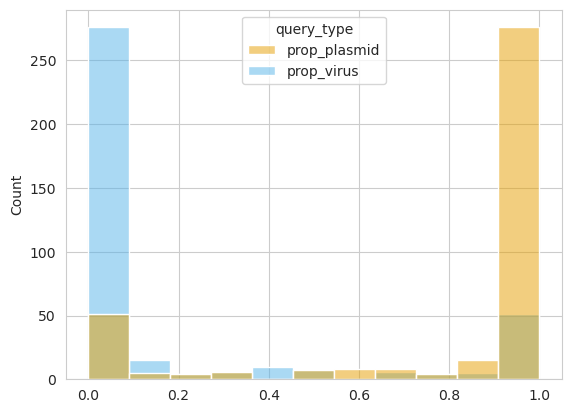

In [25]:
sns.histplot(
    dist[(dist["Plasmid"] > 0) | (dist["Virus"] > 0)].drop(
        ["Plasmid", "Virus", "Unknown"], axis=1
    )
)
plt.savefig("../figures/spacer_target_per_array_distribution.pdf", bbox_inches="tight")

In [26]:
test.columns

Index(['Contig', 'CRISPR', 'Start', 'End', 'Consensus_repeat', 'N_repeats',
       'Repeat_len', 'Spacer_len_avg', 'Repeat_identity', 'Spacer_identity',
       'Spacer_len_sem', 'Trusted', 'Prediction', 'Subtype',
       'Subtype_probability', 'taxon_oid', 'Ecosystem Subtype', 'Latitude',
       'Longitude', 'Origin', 'Isolation Country', 'Ecosystem Subtype Custom',
       'Plasmid Count', 'soil_class', 'bdod (cg/cm³)', 'cec (mmol(c)/kg)',
       'cfvo (cm³/dm³)', 'clay (g/kg)', 'nitrogen (cg/kg)', 'ocd (dg/dm³)',
       'phh2o (pH*10)', 'sand (g/kg)', 'silt (g/kg)', 'soc (dg/kg)',
       'geometry', 'index_right', 'ECO_NAME', 'WWF_REALM', 'RealmMHT',
       'WWF_REALM2', 'WWF_MHTNUM', 'WWF_MHTNAM', 'Simple_prediction', 'PTU',
       'query', 'spacer_hit', 'array_name', 'query_taxon_oid', 'hit_taxon_oid',
       'query_ecosystem', 'hit_ecosystem', 'query_ptu', 'hit_ptu', 'checkv',
       'query_votu', 'hit_votu', 'virus_taxonomy', 'query_type'],
      dtype='object')

In [ ]:
pd.DataFrame(
    test.drop_duplicates(subset=["CRISPR"])["Simple_prediction"].value_counts()
)

,count
Simple_prediction,
I,479
Unknown,416
V,29
IV,10
III,10
II,8
VI,2


In [28]:
a = pd.DataFrame(
    test.drop_duplicates(subset=["CRISPR"])["Simple_prediction"].value_counts()
)
a["Trusted"] = "Yes"
a = a.reset_index()
# a.sort_values("Simple_prediction")

In [ ]:
a

,Simple_prediction,count,Trusted
0,I,479,Yes
1,Unknown,416,Yes
2,V,29,Yes
3,IV,10,Yes
4,III,10,Yes
5,II,8,Yes
6,VI,2,Yes


<Axes: xlabel='Trusted', ylabel='Simple_prediction'>

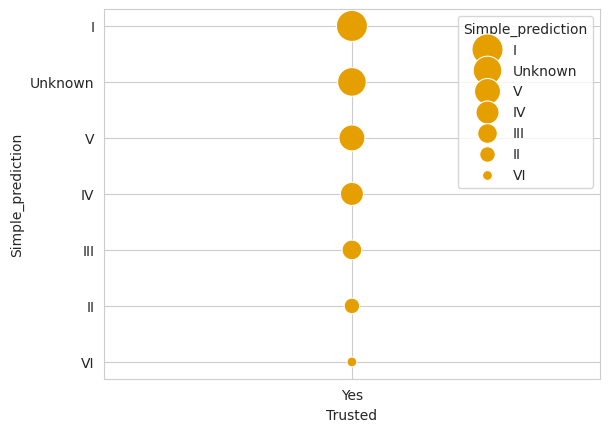

In [30]:
sns.scatterplot(
    x=a["Trusted"],
    y=a["Simple_prediction"],
    size=a["Simple_prediction"],
    sizes=(50, 500),
)

# plt.savefig("../../figures/plasmid_crisprs_simple_predictions.pdf", bbox_inches="tight")

In [31]:
b = (
    test.drop_duplicates(subset=["CRISPR"])
    .groupby("Simple_prediction")["Prediction"]
    .value_counts()
    .unstack()
    .fillna(0)
)
b = b.melt()
b["simple_prediction"] = b["Prediction"].apply(
    lambda x: x.split("-")[0] if x != "Unknown" else "Unknown"
)
b["Prediction"] = b["Prediction"].apply(
    lambda x: x.split("-")[1] if x != "Unknown" else "Unknown"
)

In [32]:
b[(b["value"] > 0)]

,Prediction,value,simple_prediction
0,A,4.0,I
7,B,11.0,I
14,C,76.0,I
21,D,12.0,I
28,E,311.0,I
35,F,17.0,I
42,F_T,1.0,I
49,G,47.0,I
57,C,8.0,II
65,A,4.0,III


<Axes: xlabel='Prediction', ylabel='simple_prediction'>

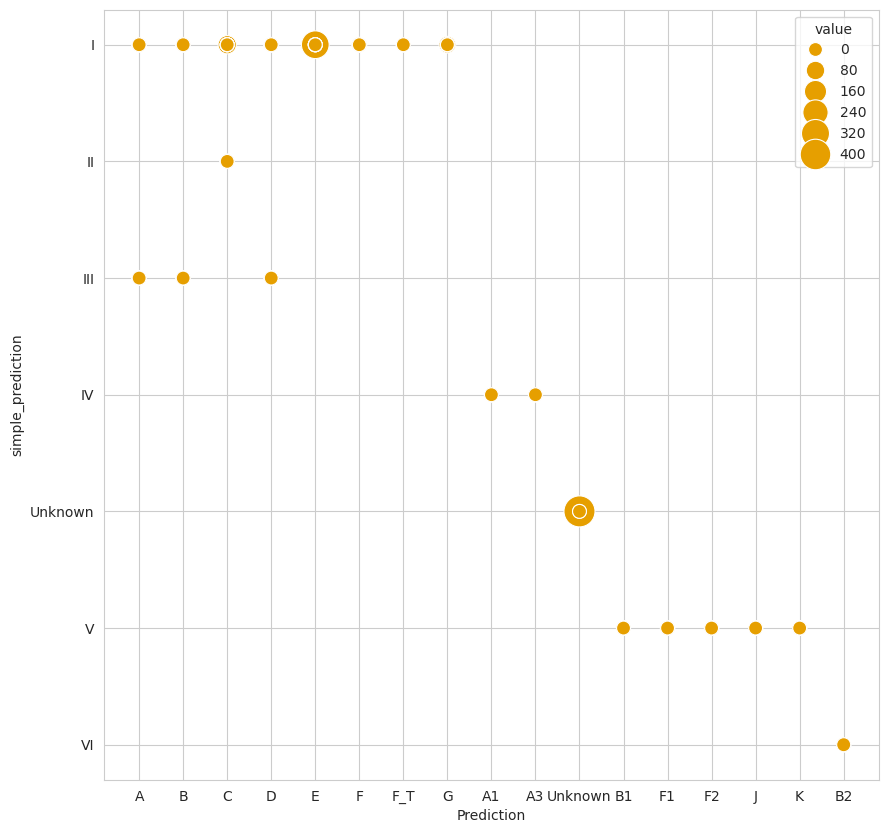

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    y=b["simple_prediction"],
    x=b["Prediction"],
    size=b["value"],
    sizes=(100, 500),
    ax=ax,
)

# plt.savefig("../../figures/plasmid_crisprs_predictions.pdf", bbox_inches="tight")

In [34]:
c = (
    test.drop_duplicates(subset=["CRISPR"])
    .groupby("Simple_prediction")["query_type"]
    .value_counts()
    .unstack()
    .fillna(0)
)
c

query_type,Plasmid,Unknown,Virus
Simple_prediction,,,
I,270.0,183.0,26.0
II,5.0,3.0,0.0
III,0.0,10.0,0.0
IV,2.0,8.0,0.0
Unknown,189.0,217.0,10.0
V,11.0,18.0,0.0
VI,2.0,0.0,0.0


/tmp/ipykernel_1684048/4117707103.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  c.T.plot.pie(subplots=True, ax=ax, legend=True, startangle=90)


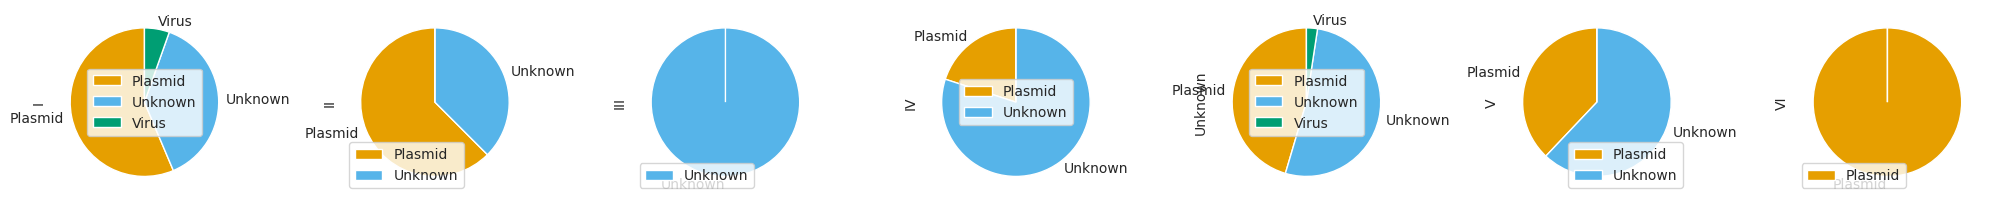

In [35]:
# make a pie chart of c dataframe
fig, ax = plt.subplots(figsize=(20, 20))
c.T.plot.pie(subplots=True, ax=ax, legend=True, startangle=90)
fig.tight_layout()
# fig.savefig("../../figures/plasmid_crisprs_query_type.pdf", bbox_inches="tight")

/tmp/ipykernel_1684048/854330534.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  d.T.plot.pie(subplots=True, ax=ax, legend=True, startangle=90)


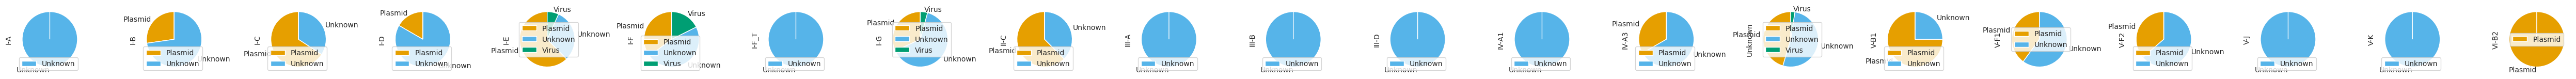

In [36]:
d = (
    test.drop_duplicates(subset=["CRISPR"])
    .groupby("Prediction")["query_type"]
    .value_counts()
    .unstack()
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(50, 50))
d.T.plot.pie(subplots=True, ax=ax, legend=True, startangle=90)
fig.tight_layout()
# fig.savefig("../../figures/plasmid_crisprs_query_subtype.pdf", bbox_inches="tight")

In [37]:
df_plasmid_crisprs["Prediction"].value_counts().sum()

954

In [ ]:
df_plasmid_crisprs["Contig"].nunique()

522

In [ ]:
a = pd.DataFrame(df_plasmid_crisprs["Simple_prediction"].value_counts())
a["Trusted"] = "Yes"
a = a.reset_index()
a.sort_values("Simple_prediction")

,Simple_prediction,count,Trusted
0,I,479,Yes
5,II,8,Yes
4,III,10,Yes
3,IV,10,Yes
1,Unknown,416,Yes
2,V,29,Yes
6,VI,2,Yes


In [ ]:
test.head()

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,checkv,query_votu,hit_votu,virus_taxonomy,query_type
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown


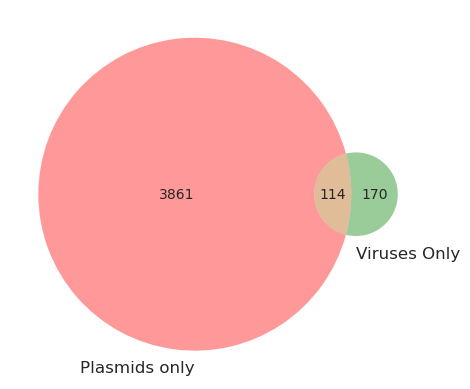

In [41]:
# spacers in plasmids
venn_hits = (
    test[test["query_type"] != "Unknown"]
    .drop_duplicates(subset=["query", "spacer_hit"])
    .groupby("spacer_hit")["query_type"]
    .value_counts()
    .unstack()
    .fillna(0)
)

fig, ax = plt.subplots()
v = venn2(
    subsets=(
        venn_hits[(venn_hits["Plasmid"] > 0) & (venn_hits["Virus"] == 0)].shape[0],
        venn_hits[(venn_hits["Plasmid"] == 0) & (venn_hits["Virus"] > 0)].shape[0],
        venn_hits[(venn_hits["Plasmid"] > 0) & (venn_hits["Virus"] > 0)].shape[0],
    ),
    set_labels=("Plasmids only", "Viruses Only"),
)

fig.savefig("../figures/plasmid_spacers_hitting_venn.pdf", bbox_inches="tight")

We saw differences [have to do some statistics here] between the number of PTUs carrying CRISPR-arrays across different soil ecosystems

In [ ]:
df_plasmid_crisprs

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,...,geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,Simple_prediction,PTU
0,2162886015|FOassembled-_contig00083,2162886015|FOassembled-_contig00083_1,17,466,CTGCTCTCCGCGCGAGCGGAGGTG,8,24.0,36.9,87.8,47.0,...,POINT (-0.37 51.8),547.0,English Lowlands Beech Forests,PA,PA4,Palearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24873
1,3300005434|Ga0070709_10000879,3300005434|Ga0070709_10000879_2,8049,8533,GTCGCAATCCCACCTGACTGATCTGGTCTCCTCCGAC,7,37.0,37.7,94.2,44.0,...,POINT (-85.45 42.48),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24268
2,3300005440|Ga0070705_100000126,3300005440|Ga0070705_100000126_3,4816,13036,GTTTCAATCCCCTCTTCATCGGGGAAGCGTCATCACC,113,37.0,36.1,100.0,41.8,...,POINT (-85.37 42.39),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24280
3,3300005467|Ga0070706_100000967,3300005467|Ga0070706_100000967_4,19520,19770,TCCCCAACGGGCGGTAGAGGCCATTCCGAC,4,30.0,43.7,96.8,51.5,...,POINT (-85.37 42.39),182.0,North Central Tillplain,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24030
4,3300005524|Ga0070737_10005481,3300005524|Ga0070737_10005481_5,10407,12092,GTCTCAGCTACGTGGCCGCTGAGCAGGCGC,24,30.0,42.0,84.6,50.4,...,POINT (-76.34 40.8),704.0,Central Appalachian Forest,NaN,NA4,Nearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-24574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,PLSDB_CP066849.1,PLSDB_CP066849.1-1_1665,47880,48108,GTCGCATCTTTCATGGGTGCGTGGATTGAAAT,4,31.8,34.0,72.5,39.8,...,POINT (23.87 52.76),538.0,Central European Mixed Forests,PA,PA4,Palearctic,4.0,Temperate Broadleaf and Mixed Forests,Unknown,PTU-02497
986,IMGPR_plasmid_2775507132_000001|2775507132|277...,IMGPR_plasmid_2775507132_000001|2775507132|277...,20382,21303,CCTGCTCCCCGCACACGCGGGGATGGTCCC,15,28.5,35.4,85.7,43.5,...,POINT EMPTY,NaN,Unknown,NaN,NaN,Unknown,NaN,Unknown,I,PTU-40448
987,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1693,46403,46820,TTTAAATCCCAAATAGTTTCAGATAAAA,7,28.0,37.0,72.2,43.1,...,POINT (97.75 64.69),594.0,East Siberian Taiga,PA,PA6,Palearctic,6.0,Boreal Forests/Taiga,Unknown,PTU-02475
988,PLSDB_NZ_CP136375.1,PLSDB_NZ_CP136375.1-1_1694,53870,54025,TTTTATCTGAACTTTGTGGGATATAAAT,3,27.3,37.0,72.6,48.0,...,POINT (97.75 64.69),594.0,East Siberian Taiga,PA,PA6,Palearctic,6.0,Boreal Forests/Taiga,Unknown,PTU-02475


In [43]:
import duckdb

with duckdb.connect("../soil_plasmid.db") as con:
    ptus = con.execute("SELECT * FROM ptu_derep").df()

ptus = ptus.set_index("pOTU")
ptus.head()

,Representative,Members,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin
pOTU,,,,,,,,,
pOTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...
pOTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...


In [44]:
env_ptu_mapping = defaultdict(list)
for idx, row in ptus.iterrows():
    for ecosystem in set(row["Ecosystem Subtype Custom"].split(";")):
        env_ptu_mapping[ecosystem].append(idx.replace("pOTU", "PTU"))

In [45]:
a = (
    df_plasmid_crisprs[df_plasmid_crisprs["Ecosystem Subtype Custom"] != "Unclassified"]
    .drop_duplicates(subset=["PTU", "Ecosystem Subtype Custom"])
    .groupby("Ecosystem Subtype Custom")["PTU"]
    .unique()
)

a = a.to_dict()

In [46]:
presence_absence = defaultdict(list)

for ecosystem, ptus in env_ptu_mapping.items():
    if ecosystem in a:
        for ptu in ptus:
            if ptu in a[ecosystem]:
                presence_absence[ecosystem].append(1)
            else:
                presence_absence[ecosystem].append(0)

In [47]:
from scipy import stats

In [48]:
stats.kruskal(*presence_absence.values())

KruskalResult(statistic=42.364233906396706, pvalue=1.5580493575920388e-07)

In [49]:
from scikit_posthocs import posthoc_dunn

dunn_test = posthoc_dunn(
    [
        presence_absence["Agricultural land"],
        presence_absence["Grasslands"],
        presence_absence["Rhizosphere"],
        presence_absence["Temperate forest"],
        presence_absence["Tropical forest"],
        presence_absence["Peat"],
        presence_absence["Other"],
    ]
)
dunn_test.index = [
    "Agricultural land",
    "Grasslands",
    "Rhizosphere",
    "Temperate forest",
    "Tropical forest",
    "Peat",
    "Other",
]
dunn_test.columns = [
    "Agricultural land",
    "Grasslands",
    "Rhizosphere",
    "Temperate forest",
    "Tropical forest",
    "Peat",
    "Other",
]
dunn_test[dunn_test < 0.05]

,Agricultural land,Grasslands,Rhizosphere,Temperate forest,Tropical forest,Peat,Other
Agricultural land,NaN,NaN,NaN,NaN,NaN,5.639944e-04,0.023407
Grasslands,NaN,NaN,NaN,NaN,NaN,6.337955e-04,0.020183
Rhizosphere,NaN,NaN,NaN,NaN,NaN,2.028766e-06,0.001237
Temperate forest,NaN,NaN,NaN,NaN,NaN,2.208383e-07,0.000261
Tropical forest,NaN,NaN,NaN,NaN,NaN,4.306265e-04,0.003859
Peat,0.000564,0.000634,0.000002,2.208383e-07,0.000431,NaN,NaN
Other,0.023407,0.020183,0.001237,2.613118e-04,0.003859,NaN,NaN


<Axes: >

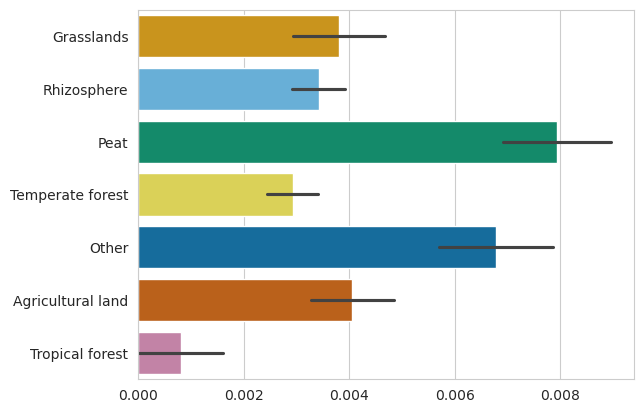

In [50]:
sns.barplot(presence_absence, orient="h", errorbar="se")

In [51]:
df_plasmid_crisprs.drop_duplicates(subset=["PTU", "Ecosystem Subtype Custom"]).groupby(
    "Ecosystem Subtype Custom"
)["PTU"].nunique()

Ecosystem Subtype Custom
Agricultural land     26
Grasslands            19
Other                 39
Peat                  60
Rhizosphere           46
Temperate forest      36
Tropical forest        1
Unclassified         215
Name: PTU, dtype: int64

CRISPRS in plasmids targeting viruses

In [52]:
test[test["query_type"] == "Virus"].drop_duplicates(subset=["PTU", "query_votu"])[
    "hit_ecosystem"
].value_counts()

hit_ecosystem
Unclassified         202
Peat                  34
Rhizosphere           14
Other                 10
Grasslands             6
Tropical forest        5
Agricultural land      4
Temperate forest       3
Name: count, dtype: int64

---
## Host analysis

In [53]:
with open("../votu/genomad_viruses_checkv.txt") as f:
    genomad_viruses = {}
    for line in f:
        k, v = line.strip().split("\t")
        genomad_viruses[k] = v

with open("../ptu_derep/derep_plasmids_ids.txt") as f:
    plasmids = set([line.strip() for line in f])

In [54]:
df_hosts = pd.read_csv(
    "../crispr_search/plasmid_host_taxonomy_consolidated_all_possible_hosts_final_derep.tsv",
    sep="\t",
    index_col=0,
)
df_hosts.head()

,host,method
Plasmid,,
2088090014|GPIPI_16557027,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,iphop-blast
2088090014|GPIPI_16557027,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,iphop-blast
2088090014|GPIPI_16944593,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,iphop-blast
2088090014|GPIPI_16944593,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,iphop-blast
2088090015|GPICI_8721071,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,iphop-blast


In [55]:
df_hosts.reset_index().drop_duplicates(subset=["Plasmid", "method"]).set_index(
    "Plasmid"
)["method"].value_counts()

method
iphop-blast        41684
iphop-iPHoP-RF     11568
isolate             8079
iphop-CRISPR         554
iphop-RaFAH          117
mmseqs-taxonomy       54
Name: count, dtype: int64

In [56]:
df_hosts.reset_index().drop_duplicates(subset=["Plasmid", "method"]).set_index(
    "Plasmid"
)["method"].value_counts().sum()

62056

53,923 plasmids could be assigned a host through iphop (87%)

In [57]:
len(set(df_hosts.index))

56764

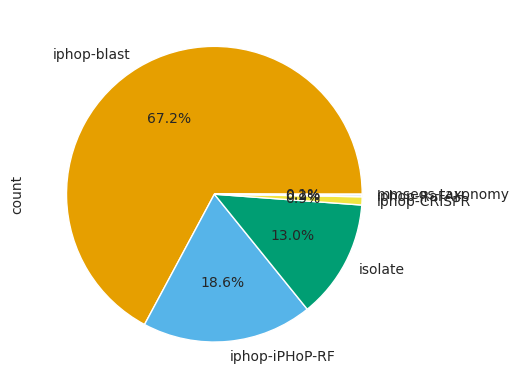

In [58]:
df_hosts.reset_index().drop_duplicates(subset=["Plasmid", "method"]).set_index(
    "Plasmid"
)["method"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.savefig("../figures/taxonomy_origin.pdf", bbox_inches="tight")

Of all iphop results, what are their hit origins? GTDB,GEM,MGnify or IMG?

In [59]:
with open("../crispr_search/gtdb_origin.tsv") as f:
    gtdb_mapping = {}
    for line in f:
        k, v = line.strip().split("\t")
        gtdb_mapping[k] = v
df_for_supp = pd.read_csv(
    "../crispr_search/derep_plasmids_host_for_suppl_fig.tsv", sep="\t"
)


def fill_source_type_from_host(row):
    """
    If the 'Source_type' is NaN, use the 'Host_genome' value to look up the corresponding
    type in the gtdb_mapping dictionary. If no mapping is found, keep the NaN.
    """
    if "MGY" in row["Host_genome"]:
        return "MGN MAG"
    elif "GB" in row["Host_genome"] or "RS" in row["Host_genome"]:
        return gtdb_mapping.get(row["Host_genome"])
    elif pd.isna(row["Source_type"]):
        return "IMG MAG"
    else:
        return row["Source_type"]


df_for_supp["Source_type"] = df_for_supp.apply(fill_source_type_from_host, axis=1)


df_for_supp.head()


,Plasmid,Host_genome,Host_taxonomy,Main_method,Confidence_score,Additional_methods,Source_type
0,2088090014|GPIPI_16557027,GB_GCA_003135455.1,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,blast,96.2,iPHoP-RF;75.20,GTDB MAG
1,2088090014|GPIPI_16944593,GB_GCA_001767435.1,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,blast,93.5,NaN,GTDB MAG
2,2088090015|GPICI_8721071,GB_GCA_004366385.1,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,92.7,iPHoP-RF;62.70,GTDB MAG
3,2088090015|GPICI_8721071,3300022899_3,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,91.0,iPHoP-RF;64.50,GEM MAG
4,2088090015|GPICI_8946463,GB_GCA_004366385.1,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,93.9,iPHoP-RF;67.30,GTDB MAG


In [60]:
df_for_supp["Source_type_2"] = df_for_supp["Source_type"].apply(
    lambda x: "GTDB MAG"
    if isinstance(x, str) and any(i in x for i in ["GTDB SAG", "GTDB Env"])
    else "IMG MAG"
    if isinstance(x, str) and "GEM MAG" in x
    else x
)
df_for_supp["Source_type_3"] = df_for_supp["Source_type_2"].apply(
    lambda x: "Isolate"
    if isinstance(x, str) and "Isolate" in x
    else "MAG"
    if isinstance(x, str) and "MAG" in x
    else x
)

In [61]:
df_for_supp["Source_type_2"].value_counts()

Source_type_2
GTDB Isolate    314310
GTDB MAG         95527
IMG MAG          34738
MGN MAG            423
IMG Isolate        264
Name: count, dtype: int64

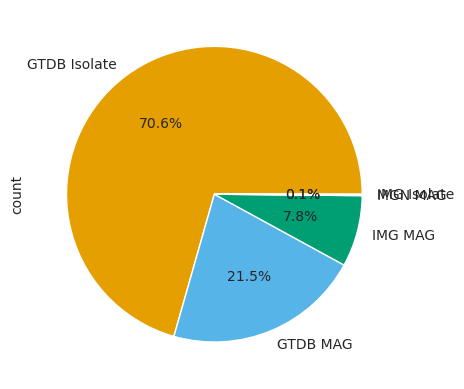

In [62]:
df_for_supp["Source_type_2"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.savefig("../figures/iphop-all_source_type_pie.pdf", bbox_inches="tight")

What about pOTUs?

In [63]:
df_for_supp["ptus"] = df_for_supp.apply(
    lambda x: ptus_mapping.get(x["Plasmid"]), axis=1
)

df_for_supp.head()


,Plasmid,Host_genome,Host_taxonomy,Main_method,Confidence_score,Additional_methods,Source_type,Source_type_2,Source_type_3,ptus
0,2088090014|GPIPI_16557027,GB_GCA_003135455.1,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,blast,96.2,iPHoP-RF;75.20,GTDB MAG,GTDB MAG,MAG,PTU-04071
1,2088090014|GPIPI_16944593,GB_GCA_001767435.1,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,blast,93.5,NaN,GTDB MAG,GTDB MAG,MAG,PTU-57264
2,2088090015|GPICI_8721071,GB_GCA_004366385.1,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,92.7,iPHoP-RF;62.70,GTDB MAG,GTDB MAG,MAG,PTU-06613
3,2088090015|GPICI_8721071,3300022899_3,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,91.0,iPHoP-RF;64.50,GEM MAG,IMG MAG,MAG,PTU-06613
4,2088090015|GPICI_8946463,GB_GCA_004366385.1,d__Bacteria;p__Actinomycetota;c__Thermoleophil...,blast,93.9,iPHoP-RF;67.30,GTDB MAG,GTDB MAG,MAG,PTU-06613


In [64]:
# How many ptus were assigned to MAGs or isolates?
grouped = df_for_supp.groupby("ptus").agg(
    sources=pd.NamedAgg(column="Source_type_3", aggfunc="unique"),
    n_sources=pd.NamedAgg(column="Source_type_3", aggfunc="nunique"),
)
grouped["sources"] = grouped["sources"].apply(lambda x: ",".join(x))

grouped.head()

,sources,n_sources
ptus,,
PTU-00000,MAG,1
PTU-00001,"MAG,Isolate",2
PTU-00002,"MAG,Isolate",2
PTU-00003,"MAG,Isolate",2
PTU-00004,MAG,1


In [65]:
grouped.shape[0]

28483

In [66]:
print(
    f"There are {grouped[grouped['sources'] == 'MAG'].shape[0]} ptus assigned to only MAGs"
)
print(
    f"There are {grouped[grouped['sources'] == 'Isolate'].shape[0]} ptus assigned to only Isolates"
)
print(
    f"There are {grouped[grouped['n_sources'] > 1].shape[0]} ptus assigned to both MAGs and Isolates"
)

There are 9637 ptus assigned to only MAGs
There are 9096 ptus assigned to only Isolates
There are 9750 ptus assigned to both MAGs and Isolates


In [67]:
# How many species were these MAGs or isolates?
df_for_supp.drop_duplicates(subset=["Host_taxonomy", "ptus"]).groupby(
    "Source_type_2"
).agg(unique_ptus=pd.NamedAgg(column="ptus", aggfunc="unique")).explode("unique_ptus")

,unique_ptus
Source_type_2,
GTDB Isolate,PTU-24921
GTDB Isolate,PTU-06617
GTDB Isolate,PTU-00830
GTDB Isolate,PTU-02043
GTDB Isolate,PTU-06619
...,...
MGN MAG,PTU-45896
MGN MAG,PTU-45640
MGN MAG,PTU-45626


In [68]:
df_for_supp[pd.isnull(df_for_supp["Source_type_3"])]

,Plasmid,Host_genome,Host_taxonomy,Main_method,Confidence_score,Additional_methods,Source_type,Source_type_2,Source_type_3,ptus


In [69]:
df_for_supp.drop_duplicates(subset=["Host_taxonomy", "ptus"]).groupby("ptus")[
    "Source_type_3"
].unique()

ptus
PTU-00000             [MAG]
PTU-00001    [MAG, Isolate]
PTU-00002    [MAG, Isolate]
PTU-00003    [MAG, Isolate]
PTU-00004             [MAG]
                  ...      
PTU-57259         [Isolate]
PTU-57261         [Isolate]
PTU-57262    [Isolate, MAG]
PTU-57263         [Isolate]
PTU-57264             [MAG]
Name: Source_type_3, Length: 28483, dtype: object

In [70]:
# df_hosts["method"].value_counts().plot(
#     kind="pie", autopct="%1.1f%%"
# )
# plt.savefig("../figures/taxonomy_origin.pdf", bbox_inches="tight")

Of those iphop-blast, what are their hit origins? GTDB,GEM,MGnify or IMG?

In [71]:
df_hosts2 = pd.read_csv(
    "../crispr_search/iphop-blast_final_unique_sources_derep.tsv", sep="\t"
)
df_hosts2.head()

FileNotFoundError: [Errno 2] No such file or directory: '../crispr_search/iphop-blast_final_unique_sources_derep.tsv'

In [52]:
df_hosts2["Source_type2"] = df_hosts2["Source_type"].apply(
    lambda x: (
        "GTDB MAG"
        if any(i for i in ["SAG", "Env"] if i in x)
        else "IMG MAG"
        if "GEM" in x
        else x
    )
)

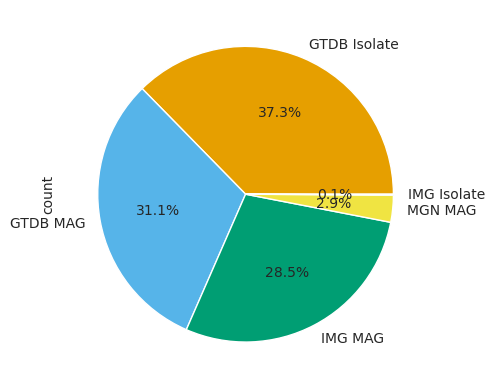

In [53]:
df_hosts2["Source_type2"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.savefig("../figures/iphop-blast_source_type_pie.pdf", bbox_inches="tight")

In [54]:
# df_hosts2["Source_type"].value_counts().plot(
#     kind="pie", autopct="%1.1f%%", wedgeprops=dict(width=0.3)
# )
# plt.savefig("../../figures/iphop-blast_source_type_pie.pdf", bbox_inches="tight")

---

## Crispr hits in all MetaG contigs

In [72]:
# votus
votus = pd.read_csv(
    "../votu/genomad_viruses_clusters_filtered_with_votu_ids.tsv",
    sep="\t",
    index_col=0,
    header=None,
)

votus_mapping = {}
for votu in votus.index:
    for virus in votus.loc[votu, 2].split(","):
        votus_mapping[virus] = votu

In [73]:
with open("../ptu_derep/derep_plasmids_ids_img_fixed.txt") as f:
    plasmids = set([line.strip() for line in f])

with open("../votu/genomad_viruses_checkv.txt") as f:
    genomad_viruses_dict = {}
    for line in f:
        line = line.strip().split("\t")
        genomad_viruses_dict[line[0]] = line[1]

In [74]:
df = pd.read_csv(
    "../crispr_search/meta_spacers/blastn_consolidated.tsv", sep="\t", header=None
)

df.columns = ["query", "spacer_hit"]

df["spacer_hit"] = df["spacer_hit"].str.split(",")

# Remove hits with only one spacer
df["num_hits"] = df["spacer_hit"].apply(len)
df = df[df["num_hits"] > 1]


df = df.explode("spacer_hit")
df["hit_name"] = df["spacer_hit"].apply(lambda x: "_".join(x.split("_")[0:-1]))
df["array_name"] = df["spacer_hit"].apply(lambda x: ":".join(x.split(":")[0:-1]))

df["hit_is_plasmid"] = df["hit_name"].apply(lambda x: x in plasmids)
df["hit_is_virus"] = df["hit_name"].apply(lambda x: x in genomad_viruses_dict.keys())
df["query_is_virus"] = df["query"].apply(lambda x: x in genomad_viruses_dict.keys())
df["query_is_plasmid"] = df["query"].apply(lambda x: x in plasmids)


# Remove hits to self
df = df[df["query"] != df["hit_name"]]


# Add taxon_oid of the query and ecosystem
df["query_taxon_oid"] = df["query"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)
df["hit_taxon_oid"] = df["hit_name"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

df["query_ecosystem"] = (
    df["query_taxon_oid"].map(df_env["Ecosystem Subtype Custom"]).fillna("Unclassified")
)

df["hit_ecosystem"] = df["hit_taxon_oid"].map(df_env["Ecosystem Subtype Custom"])

df = df.drop("num_hits", axis=1)

df["query_ptu"] = df["query"].map(ptus_mapping)
df["hit_ptu"] = df["hit_name"].map(ptus_mapping)
df["hit_votu"] = df["hit_name"].map(votus_mapping)

df = df[(df["query_is_plasmid"]) | (df["query_is_virus"])]
df.head()

,query,spacer_hit,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,hit_votu
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,True,False,False,True,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10009382_35:23,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10001069_28:23,3300003323|rootH1_10001069,3300003323|rootH1_10001069_28,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN


In [75]:
df_virus = pd.read_csv(
    "../crispr_search/meta_spacers/blastn_consolidated_viruses.tsv",
    sep="\t",
    header=None,
)

df_virus_taxonomy = pd.read_csv(
    "../votu/all_genomad_viruses_summary_filtered.tsv",
    sep="\t",
    index_col=0,
    usecols=["seq_name", "taxonomy"],
)

df_virus.columns = ["query", "spacer_hit"]
df_virus["checkv"] = df_virus["query"].apply(
    lambda x: genomad_viruses_dict.get(x, np.nan)
)

df_virus["spacer_hit"] = df_virus["spacer_hit"].str.split(",")

# Remove hits with only one spacer
df_virus["num_hits"] = df_virus["spacer_hit"].apply(len)
df_virus = df_virus[df_virus["num_hits"] > 1]


df_virus = df_virus.explode("spacer_hit")
df_virus["hit_name"] = df_virus["spacer_hit"].apply(
    lambda x: "_".join(x.split("_")[0:-1])
)
df_virus["array_name"] = df_virus["spacer_hit"].apply(
    lambda x: ":".join(x.split(":")[0:-1])
)

df_virus["hit_is_plasmid"] = df_virus["hit_name"].apply(lambda x: x in plasmids)
df_virus["hit_is_virus"] = df_virus["hit_name"].apply(lambda x: x in genomad_viruses)
df_virus["query_is_virus"] = df_virus["query"].apply(lambda x: x in genomad_viruses)
df_virus["query_is_plasmid"] = df_virus["query"].apply(lambda x: x in plasmids)

# Remove hits to self
df_virus = df_virus[df_virus["query"] != df_virus["hit_name"]]


# Add taxon_oid of the query and ecosystem
df_virus["query_taxon_oid"] = df_virus["query"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)
df_virus["hit_taxon_oid"] = df_virus["hit_name"].apply(
    lambda x: x.split("_")[2] if "IMGPR" in x else x.split("|")[0]
)

df_virus["query_ecosystem"] = (
    df_virus["query_taxon_oid"]
    .map(df_env["Ecosystem Subtype Custom"])
    .fillna("Unclassified")
)

df_virus["hit_ecosystem"] = df_virus["hit_taxon_oid"].map(
    df_env["Ecosystem Subtype Custom"]
)

df_virus = df_virus.drop("num_hits", axis=1)

df_virus["query_votu"] = df_virus["query"].map(votus_mapping)
df_virus["hit_ptu"] = df_virus["hit_name"].map(ptus_mapping)
df_virus["hit_votu"] = df_virus["hit_name"].map(votus_mapping)
df_virus = df_virus.join(df_virus_taxonomy, on="query").rename(
    columns={"taxonomy": "virus_taxonomy"}
)
df_virus = df_virus.dropna(subset="checkv")


df_virus.head()

,query,spacer_hit,checkv,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_votu,hit_ptu,hit_votu,virus_taxonomy
1,2124908027|MRS2a_Contig_206,MGYA00521144|ERZ807544.118-NODE-118-length-692...,High-quality,MGYA00521144|ERZ807544.118-NODE-118-length-692...,MGYA00521144|ERZ807544.118-NODE-118-length-692...,False,False,True,False,2124908027,MGYA00521144,Rhizosphere,Rhizosphere,vOTU003985,NaN,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
1,2124908027|MRS2a_Contig_206,MGYA00521144|ERZ807544.118-NODE-118-length-692...,High-quality,MGYA00521144|ERZ807544.118-NODE-118-length-692...,MGYA00521144|ERZ807544.118-NODE-118-length-692...,False,False,True,False,2124908027,MGYA00521144,Rhizosphere,Rhizosphere,vOTU003985,NaN,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
1,2124908027|MRS2a_Contig_206,MGYA00375037|ERZ781227.597-NODE-597-length-221...,High-quality,MGYA00375037|ERZ781227.597-NODE-597-length-221...,MGYA00375037|ERZ781227.597-NODE-597-length-221...,False,False,True,False,2124908027,MGYA00375037,Rhizosphere,Rhizosphere,vOTU003985,NaN,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
1,2124908027|MRS2a_Contig_206,MGYA00375037|ERZ781227.597-NODE-597-length-221...,High-quality,MGYA00375037|ERZ781227.597-NODE-597-length-221...,MGYA00375037|ERZ781227.597-NODE-597-length-221...,False,False,True,False,2124908027,MGYA00375037,Rhizosphere,Rhizosphere,vOTU003985,NaN,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
1,2124908027|MRS2a_Contig_206,3300015265|Ga0182005_1000393_7:3,High-quality,3300015265|Ga0182005_1000393,3300015265|Ga0182005_1000393_7,False,False,True,False,2124908027,3300015265,Rhizosphere,Rhizosphere,vOTU003985,NaN,NaN,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...


In [76]:
df_crispr_types = pd.read_csv(
    "../crispr_search/meta_spacers/all_assemblies_crisprs.tsv", sep="\t"
)

df_crispr_types.head()

,Contig,CRISPR,Start,End,Consensus_repeat,N_repeats,Repeat_len,Spacer_len_avg,Repeat_identity,Spacer_identity,Spacer_len_sem,Trusted,Prediction,Subtype,Subtype_probability
0,2088090014|GPIPI_16768885,2088090014|GPIPI_16768885_1,1070,3313,GTTTCGATCCCTCGTAGGGGCGATGAGGAC,34,30.0,37.1,100.0,44.9,0.4,True,I-B,I-B,0.796
1,2088090014|GPIPI_17254653,2088090014|GPIPI_17254653_2,3285,3778,GTTTCTATACGCCCTTCGGCGTGACGTGGTTCTGGAC,7,37.0,39.2,95.7,45.2,0.7,True,Unknown,III-B,0.479
2,2088090014|GPIPI_16519732,2088090014|GPIPI_16519732_3,363,1242,GATGCCGAAAGGCGTTGAGCACT,13,23.0,48.4,90.4,52.8,0.4,True,Unknown,I-A,0.690
3,2088090015|GPICI_8927674,2088090015|GPICI_8927674_4,6001,6483,GTTGCGATCCTCGCCGACCCCGGAGGGCCGGTGCTGC,7,37.0,37.3,94.2,44.0,0.6,True,I-C,I-C,0.763
4,2162886008|PRSSGFe2_Sequence0000000362,2162886008|PRSSGFe2_Sequence0000000362_5,6967,7195,TATTTAAAATATATAATATTAGATTAAAAC,4,30.0,36.3,82.3,40.7,0.3,True,I-B,I-B,0.994


In [77]:
def consolidate_hit_type(row):
    if row["hit_is_virus"] and row["hit_is_plasmid"]:
        return "Virus/Plasmid"
    elif row["hit_is_virus"] and not row["hit_is_plasmid"]:
        return "Virus"
    elif not row["hit_is_virus"] and row["hit_is_plasmid"]:
        return "Plasmid"
    else:
        return "Host"


def consolidate_query_type(row):
    if row["query_is_virus"] and row["query_is_plasmid"]:
        return "Virus/Plasmid"
    elif row["query_is_virus"] and not row["query_is_plasmid"]:
        return "Virus"
    elif not row["query_is_virus"] and row["query_is_plasmid"]:
        return "Plasmid"
    else:
        return "Host"


final_df = (
    pd.concat([df, df_virus])
    .join(
        df_crispr_types[
            ["Contig", "Trusted", "Prediction", "Subtype", "Subtype_probability"]
        ].set_index("Contig"),
        on="hit_name",
    )
    .drop_duplicates()
)
final_df = final_df[final_df["Trusted"] == True]
final_df["hit_type"] = final_df.apply(consolidate_hit_type, axis=1)
final_df["query_type"] = final_df.apply(consolidate_query_type, axis=1)
final_df = final_df.drop(
    ["hit_is_virus", "hit_is_plasmid", "query_is_plasmid", "query_is_virus"], axis=1
)
final_df.head()

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,hit_votu,checkv,query_votu,virus_taxonomy,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,NaN,NaN,NaN,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN,NaN,NaN,NaN,True,Unknown,I-E,0.739,Host,Plasmid
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN,NaN,NaN,NaN,True,Unknown,IV-A1,0.693,Host,Plasmid
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN,NaN,NaN,NaN,True,IV-A1,IV-A1,0.948,Host,Plasmid
2,3300003316|rootH1_10000298,3300003323|rootH1_10009382_35:23,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN,NaN,NaN,NaN,True,IV-A1,IV-A1,0.888,Host,Plasmid


In [78]:
df_mmseqs = pd.read_csv(
    "../crispr_search/meta_spacers/all_assemblies_with_crisprs_taxonomy_lca.tsv",
    sep="\t",
    header=None,
)
df_mmseqs = df_mmseqs[[0, 8]].rename(columns={0: "contig", 8: "hit_taxonomy"})
df_mmseqs["hit_taxonomy"] = df_mmseqs["hit_taxonomy"].apply(
    lambda x: x.replace("_", "__") if isinstance(x, str) else x
)
df_mmseqs.head()

,contig,hit_taxonomy
0,3300048780|Ga0495364_001319,d__Bacteria;p__Actinomycetota;c__Acidimicrobii...
1,3300048780|Ga0495364_002222,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...
2,3300048780|Ga0495364_002635,d__Bacteria
3,3300048780|Ga0495364_006366,d__Bacteria
4,3300048780|Ga0495364_012603,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...


In [79]:
def get_contig_type(row):
    if row["contig"] in plasmids:
        return "Plasmid"
    elif row["contig"] in genomad_viruses:
        return "Virus"
    else:
        return "Organism"


df_mmseqs["contig_type"] = df_mmseqs.apply(get_contig_type, axis=1)
df_mmseqs.head()

,contig,hit_taxonomy,contig_type
0,3300048780|Ga0495364_001319,d__Bacteria;p__Actinomycetota;c__Acidimicrobii...,Organism
1,3300048780|Ga0495364_002222,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,Organism
2,3300048780|Ga0495364_002635,d__Bacteria,Organism
3,3300048780|Ga0495364_006366,d__Bacteria,Organism
4,3300048780|Ga0495364_012603,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Plasmid


In [80]:
final_df = final_df.join(df_mmseqs.set_index("contig"), on="hit_name")
final_df.head()

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,query_votu,virus_taxonomy,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,NaN,NaN,True,Unknown,I-E,0.739,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,NaN,NaN,True,Unknown,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,NaN,NaN,True,IV-A1,IV-A1,0.948,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism
2,3300003316|rootH1_10000298,3300003323|rootH1_10009382_35:23,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,NaN,NaN,True,IV-A1,IV-A1,0.888,Host,Plasmid,d__Bacteria,Organism


In [81]:
final_df = final_df.join(
    df_hosts.rename(columns={"host": "plasmid_host"})["plasmid_host"], on="query"
)
final_df = final_df[
    (final_df["checkv"] != "Not-determined") & (final_df["checkv"] != "Low-quality")
]
final_df.head()

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,virus_taxonomy,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...


In [82]:
final_df[(final_df["hit_type"] == "Host") & (final_df["query_type"] == "Virus")][
    "spacer_hit"
].nunique()

5983

In [83]:
# print(
#     f"{final_df['spacer_hit'].nunique()} unique spacers, from {final_df['array_name'].nunique()} arrays, in {final_df['hit_name'].nunique()} contigs"
# )

In [84]:
print(
    f"{final_df[final_df['hit_type'] == 'Host']['spacer_hit'].nunique()} unique spacers, from {final_df[final_df['hit_type'] == 'Host']['array_name'].nunique()} arrays, in {final_df[final_df['hit_type'] == 'Host']['hit_name'].nunique()} contigs"
)

9864 unique spacers, from 2276 arrays, in 2096 contigs


---

In [85]:
final_df[final_df["hit_type"] == "Plasmid"]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,virus_taxonomy,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,NaN,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051204|Ga0506537_0000356_26:41,3300051204|Ga0506537_0000356,3300051204|Ga0506537_0000356_26,3300061638,3300051204,Temperate forest,Agricultural land,NaN,PTU-02105,...,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,True,I-G,I-G,0.844,Plasmid,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia,Plasmid,NaN
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051099|Ga0506495_0000761_38:38,3300051099|Ga0506495_0000761,3300051099|Ga0506495_0000761_38,3300061638,3300051099,Temperate forest,Agricultural land,NaN,PTU-02105,...,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,True,I-G,I-G,0.844,Plasmid,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia,Plasmid,NaN
10250,MGYA00645762|ERZ12633431.148-NODE-148-length-5...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645762,MGYA00645700,Rhizosphere,Rhizosphere,NaN,PTU-06230,...,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,True,Unknown,I-B,0.138,Plasmid,Virus,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,Plasmid,NaN
10250,MGYA00645762|ERZ12633431.148-NODE-148-length-5...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645700|ERZ12633433.5-NODE-5-length-27646...,MGYA00645762,MGYA00645700,Rhizosphere,Rhizosphere,NaN,PTU-06230,...,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,True,Unknown,I-F_T,0.459,Plasmid,Virus,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,Plasmid,NaN


In [86]:
final_df["Simple_prediction"] = final_df["Prediction"].apply(
    lambda x: x.split("-")[0] if x != "Unknown" else "Unknown"
)

In [87]:
final_df.head()

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I


---
## Arrays hitting plasmids, viruses and both

In [88]:
arrays_hitting = defaultdict(set)
for idx, row in final_df[final_df["hit_type"] == "Host"].iterrows():
    if row["query_type"] == "Plasmid":
        arrays_hitting[row["array_name"]].add("Plasmid")
    elif row["query_type"] == "Virus":
        arrays_hitting[row["array_name"]].add("Virus")

arrays_hitting_both = {k: v for k, v in arrays_hitting.items() if len(v) > 1}
arrays_hitting_plasmids = {
    k: v for k, v in arrays_hitting.items() if len(v) == 1 and "Plasmid" in v
}
arrays_hitting_viruses = {
    k: v for k, v in arrays_hitting.items() if len(v) == 1 and "Virus" in v
}

print(
    f"Number of unique arrays hitting both plasmids and viruses: {len(arrays_hitting_both)}"
)
print(f"Number of unique arrays hitting only plasmids: {len(arrays_hitting_plasmids)}")
print(f"Number of unique arrays hitting only viruses: {len(arrays_hitting_viruses)}")

Number of unique arrays hitting both plasmids and viruses: 221
Number of unique arrays hitting only plasmids: 368
Number of unique arrays hitting only viruses: 1687


In [89]:
final_df.head()

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I


In [90]:
final_df[final_df["hit_type"] == "Plasmid"].drop_duplicates(
    subset=["query", "hit_name"]
)[["query", "spacer_hit", "hit_name", "hit_type"]]

,query,spacer_hit,hit_name,hit_type
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,Plasmid
21,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_106:1,3300027965|Ga0209062_1000993,Plasmid
25,3300005548|Ga0070665_100000073,3300028379|Ga0268266_10001846_2:18,3300028379|Ga0268266_10001846,Plasmid
25,3300005548|Ga0070665_100000073,3300028379|Ga0268266_10000717_330:1,3300028379|Ga0268266_10000717,Plasmid
28,3300005577|Ga0068857_100000035,3300026116|Ga0207674_10000017_2:12,3300026116|Ga0207674_10000017,Plasmid
...,...,...,...,...
9595,3300056791|Ga0562384_01879,3300048769|Ga0494733_0000079_60:14,3300048769|Ga0494733_0000079,Plasmid
9765,3300061179|Ga0597116_0000194,3300053168|Ga0494695_000487_88:20,3300053168|Ga0494695_000487,Plasmid
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051204|Ga0506537_0000356_26:41,3300051204|Ga0506537_0000356,Plasmid
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051099|Ga0506495_0000761_38:38,3300051099|Ga0506495_0000761,Plasmid


In [91]:
final_df[final_df["hit_type"] == "Plasmid"].drop_duplicates(
    subset=["query", "hit_name"]
)["query_type"].value_counts()

query_type
Virus      315
Plasmid    292
Name: count, dtype: int64

In [92]:
final_df[final_df["spacer_hit"] == "3300009094|Ga0111539_10011221_1:1"].drop_duplicates(
    subset=["query", "spacer_hit"]
)

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
185,3300027907|Ga0207428_10009472,3300009094|Ga0111539_10011221_1:1,3300009094|Ga0111539_10011221,3300009094|Ga0111539_10011221_1,3300027907,3300009094,Rhizosphere,Rhizosphere,PTU-02686,PTU-02686,...,True,Unknown,I-G,0.543,Plasmid,Plasmid,d__Bacteria,Plasmid,d__Bacteria;p__Acidobacteriota;c__Blastocatell...,Unknown
1142,3300050511|nmdc:mga08y16_12780_c1,3300009094|Ga0111539_10011221_1:1,3300009094|Ga0111539_10011221,3300009094|Ga0111539_10011221_1,3300050511,3300009094,Rhizosphere,Rhizosphere,PTU-02686,PTU-02686,...,True,Unknown,I-G,0.543,Plasmid,Plasmid,d__Bacteria,Plasmid,NaN,Unknown


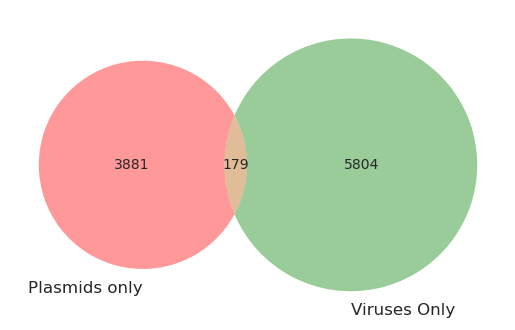

In [93]:
# spacers in hosts (chromosomes)
test = (
    final_df[final_df["hit_type"] == "Host"]
    .drop_duplicates(subset=["query", "spacer_hit"])
    .groupby("spacer_hit")["query_type"]
    .value_counts()
    .unstack()
    .fillna(0)
)

fig, ax = plt.subplots()
v = venn2(
    subsets=(
        test[(test["Plasmid"] > 0) & (test["Virus"] == 0)].shape[0],
        test[(test["Plasmid"] == 0) & (test["Virus"] > 0)].shape[0],
        test[(test["Plasmid"] > 0) & (test["Virus"] > 0)].shape[0],
    ),
    set_labels=("Plasmids only", "Viruses Only"),
)

fig.savefig("../figures/host_spacers_hitting_venn.pdf", bbox_inches="tight")

What are these plasmids being targeted by host arrays?

In [94]:
with open("host_crispr_targeted_plasmids", "w") as f:
    for i in final_df[
        (final_df["hit_type"] == "Host") & (final_df["query_type"] == "Plasmid")
    ]["query"].unique():
        f.write(i + "\n")

In [95]:
# fig, ax = plt.subplots()
# v = venn2(
#     subsets=(
#         len(arrays_hitting_plasmids),
#         len(arrays_hitting_viruses),
#         len(arrays_hitting_both),
#     ),
#     set_labels=("Plasmids only", "Viruses Only"),
# )

# fig.savefig("../../figures/arrays_hitting_venn.pdf", bbox_inches="tight")

In [96]:
# fig, ax = plt.subplots()
# v = venn2(
#     subsets=(
#         len(arrays_hitting_plasmids),
#         len(arrays_hitting_viruses),
#         len(arrays_hitting_both),
#     ),
#     set_labels=("Plasmids only", "Viruses Only"),
# )

# fig.savefig("../../figures/arrays_hitting_venn.pdf", bbox_inches="tight")

Hyper targeting

In [97]:
hyper = final_df.drop_duplicates(subset=["query", "spacer_hit"])
hyper = hyper[hyper["query_ptu"] != hyper["hit_ptu"]]

In [98]:
hyper.columns

Index(['query', 'spacer_hit', 'hit_name', 'array_name', 'query_taxon_oid',
       'hit_taxon_oid', 'query_ecosystem', 'hit_ecosystem', 'query_ptu',
       'hit_ptu', 'hit_votu', 'checkv', 'query_votu', 'virus_taxonomy',
       'Trusted', 'Prediction', 'Subtype', 'Subtype_probability', 'hit_type',
       'query_type', 'hit_taxonomy', 'contig_type', 'plasmid_host',
       'Simple_prediction'],
      dtype='object')

In [99]:
hyper_targeting = (
    hyper[(hyper["query_type"] == "Plasmid") | (hyper["hit_type"] == "Plasmid")]
    .groupby(["query", "hit_name"])
    .size()
    .sort_values(ascending=False)
)

In [100]:
hyper_df = pd.DataFrame(hyper_targeting[hyper_targeting > 20]).reset_index()
hyper_df["target_type"] = "Plasmid"

hyper_df = hyper_df.join(
    hyper[["hit_name", "hit_type"]].set_index("hit_name"), on="hit_name"
)
hyper_df = hyper_df.rename(
    columns={"query": "Target", "hit_name": "Source", 0: "weight"}
)
hyper_df = hyper_df.join(
    hyper[["hit_name", "hit_taxonomy"]].set_index("hit_name"), on="Source"
)
hyper_df = hyper_df.join(
    hyper[["hit_name", "hit_ecosystem"]].drop_duplicates().set_index("hit_name"),
    on="Source",
)
hyper_df = hyper_df.join(
    hyper[["query", "query_ecosystem"]].drop_duplicates().set_index("query"),
    on="Target",
)
hyper_df = hyper_df.drop_duplicates(subset=["Target", "Source"])
hyper_df["host_order"] = hyper_df["hit_taxonomy"].apply(
    lambda x: x.split(";")[3] if ";o__" in x else "Unknown"
)
hyper_df

,Target,Source,weight,target_type,hit_type,hit_taxonomy,hit_ecosystem,query_ecosystem,host_order
0,3300025921|Ga0207652_10000327,3300005530|Ga0070679_100001002,138,Plasmid,Host,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Rhizosphere,Rhizosphere,o__Chitinophagales
1,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964,128,Plasmid,Host,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Peat,Peat,o__Bryobacterales
2,3300020131|Ga0196972_1000181,3300021066|Ga0196980_1000004,92,Plasmid,Host,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Other,Other,o__Methylococcales
3,3300009101|Ga0105247_10000337,3300014968|Ga0157379_10008648,78,Plasmid,Host,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Rhizosphere,Rhizosphere,o__Mycobacteriales
4,3300025900|Ga0207710_10000256,3300014968|Ga0157379_10008648,78,Plasmid,Host,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Rhizosphere,Rhizosphere,o__Mycobacteriales
...,...,...,...,...,...,...,...,...,...
156,3300049823|Ga0501044_0000199,3300049571|Ga0501034_0006343,22,Plasmid,Host,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Rhizosphere,Rhizosphere,o__Streptomycetales
157,3300049568|Ga0501031_0000020,3300049571|Ga0501034_0006343,22,Plasmid,Host,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Rhizosphere,Rhizosphere,o__Streptomycetales
158,3300020147|Ga0196976_1000481,3300029659|Ga0206094_100034,22,Plasmid,Host,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Other,Other,o__Methylococcales
159,3300051204|Ga0506537_0000356,3300051238|Ga0506494_0019438,21,Plasmid,Host,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Agricultural land,Agricultural land,o__Mycobacteriales


In [101]:
# hyper_df.to_csv('hyper_targeting.csv', index=False)

In [102]:
hyper_df["Source"] = (
    hyper_df["Source"]
    + " ("
    + hyper_df["hit_type"]
    + ")"
    + " ("
    + hyper_df["host_order"]
    + ")"
    + " ("
    + hyper_df["hit_ecosystem"]
    + ")"
)
hyper_df["Target"] = hyper_df["Target"] + " (" + hyper_df["query_ecosystem"] + ")"

In [103]:
# hyper_df.to_csv('hyper_targeting.csv', index=False)

In [104]:
hyper[
    (hyper["query"] == "3300025921|Ga0207652_10000327")
    & (hyper["hit_name"] == "3300005530|Ga0070679_100001002")
]["hit_taxonomy"].unique()

array(['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Chitinophagaceae;g__Hanamia;s__Hanamia caeni'],
      dtype=object)

In [105]:
hyper_df["hit_type"].unique()

array(['Host', 'Plasmid'], dtype=object)

In [106]:
hyper[
    (hyper["query"] == "3300056587|Ga0562382_02283")
    & (hyper["hit_name"] == "3300056791|Ga0562384_07964")
]["hit_taxonomy"]

1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
                              ...                        
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1254    d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
Name: hit_taxonomy, Length: 128, dtype: object

In [107]:
hyper[
    (hyper["query"] == "3300056587|Ga0562382_02283")
    & (hyper["hit_name"] == "3300056791|Ga0562384_07964")
]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_46:16,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_46,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_46:1,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_46,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:6,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_46:9,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_46,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:21,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:19,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:67,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:25,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I
1254,3300056587|Ga0562382_02283,3300056791|Ga0562384_07964_45:15,3300056791|Ga0562384_07964,3300056791|Ga0562384_07964_45,3300056587,3300056791,Peat,Peat,PTU-37656,NaN,...,True,I-D,I-D,0.838,Host,Plasmid,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...,Organism,NaN,I


In [108]:
hyper[
    (hyper["query"].isin(hyper_targeting.index.get_level_values(0)))
    & (hyper["hit_name"].isin(hyper_targeting.index.get_level_values(1)))
].drop_duplicates(subset=["query", "hit_name"])

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,...,True,I-E,I-E,0.993,Plasmid,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,I
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,I-E,0.739,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,IV-A1,IV-A1,0.948,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,IV
2,3300003316|rootH1_10000298,3300003323|rootH1_10009382_35:23,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,IV-A1,IV-A1,0.888,Host,Plasmid,d__Bacteria,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,IV
2,3300003316|rootH1_10000298,3300003323|rootH1_10001069_28:23,3300003323|rootH1_10001069,3300003323|rootH1_10001069_28,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,I-E,0.555,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051204|Ga0506537_0000356_26:41,3300051204|Ga0506537_0000356,3300051204|Ga0506537_0000356_26,3300061638,3300051204,Temperate forest,Agricultural land,NaN,PTU-02105,...,True,I-G,I-G,0.844,Plasmid,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia,Plasmid,NaN,I
9801,3300061638|Ga0597068_0000256|provirus_7943_50590,3300051099|Ga0506495_0000761_38:38,3300051099|Ga0506495_0000761,3300051099|Ga0506495_0000761_38,3300061638,3300051099,Temperate forest,Agricultural land,NaN,PTU-02105,...,True,I-G,I-G,0.844,Plasmid,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia,Plasmid,NaN,I
10250,MGYA00645762|ERZ12633431.148-NODE-148-length-5...,MGYA00645778|ERZ12633432.16-NODE-16-length-157...,MGYA00645778|ERZ12633432.16-NODE-16-length-157...,MGYA00645778|ERZ12633432.16-NODE-16-length-157...,MGYA00645762,MGYA00645778,Rhizosphere,Rhizosphere,NaN,NaN,...,True,Unknown,I-B,0.138,Host,Virus,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,Organism,NaN,Unknown
10250,MGYA00645762|ERZ12633431.148-NODE-148-length-5...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645762,MGYA00645760,Rhizosphere,Rhizosphere,NaN,NaN,...,True,Unknown,IV-A1,0.319,Host,Virus,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,Organism,NaN,Unknown


---
## For arrays hitting plasmids and viruses

Get these cases and check if they share genes

In [109]:
final_df[
    (final_df["array_name"].isin(arrays_hitting_both.keys()))
    & (final_df["query_type"] == "Plasmid")
]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,I-E,0.739,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,I-E,0.739,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,I-E,0.739,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,True,Unknown,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,Refsoil_NC_021594.1,3300036782|Ga0376654_0000015_34:5,3300036782|Ga0376654_0000015,3300036782|Ga0376654_0000015_34,Refsoil_NC_021594.1,3300036782,Unclassified,Tropical forest,PTU-06031,NaN,...,True,I-F,I-F,1.000,Host,Plasmid,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Organism,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,I
1993,Refsoil_NC_021728.1,3300027711|Ga0209075_1006497_203:8,3300027711|Ga0209075_1006497,3300027711|Ga0209075_1006497_203,Refsoil_NC_021728.1,3300027711,Unclassified,Agricultural land,PTU-14875,NaN,...,True,I-C,I-C,0.955,Host,Plasmid,d__Bacteria,Organism,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,I
1993,Refsoil_NC_021728.1,3300006801|Ga0079223_10014474_9:8,3300006801|Ga0079223_10014474,3300006801|Ga0079223_10014474_9,Refsoil_NC_021728.1,3300006801,Unclassified,Agricultural land,PTU-14875,NaN,...,True,I-C,I-C,0.955,Host,Plasmid,d__Bacteria;p__Pseudomonadota,Organism,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,I
1994,Refsoil_NC_021732.1,3300027711|Ga0209075_1006497_203:8,3300027711|Ga0209075_1006497,3300027711|Ga0209075_1006497_203,Refsoil_NC_021732.1,3300027711,Unclassified,Agricultural land,PTU-14875,NaN,...,True,I-C,I-C,0.955,Host,Plasmid,d__Bacteria,Organism,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,I


In [110]:
final_df[
    (final_df["array_name"].isin(arrays_hitting_both.keys()))
    & (final_df["query_type"] == "Virus")
]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction
37,3300003316|rootH1_10003752,3300049579|Ga0501043_0019433_15:23,3300049579|Ga0501043_0019433,3300049579|Ga0501043_0019433_15,3300003316,3300049579,Unclassified,Rhizosphere,NaN,NaN,...,True,Unknown,IV-D,0.601,Host,Virus,d__Bacteria;p__Actinomycetota,Organism,NaN,Unknown
37,3300003316|rootH1_10003752,3300049573|Ga0501037_0010959_56:22,3300049573|Ga0501037_0010959,3300049573|Ga0501037_0010959_56,3300003316,3300049573,Unclassified,Rhizosphere,NaN,NaN,...,True,Unknown,IV-D,0.601,Host,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,NaN,Unknown
45,3300003316|rootH1_10000379,3300025949|Ga0207667_10001621_13:31,3300025949|Ga0207667_10001621,3300025949|Ga0207667_10001621_13,3300003316,3300025949,Unclassified,Rhizosphere,NaN,NaN,...,True,I-F,I-F,0.998,Host,Virus,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Organism,NaN,I
45,3300003316|rootH1_10000379,3300005563|Ga0068855_100006205_12:31,3300005563|Ga0068855_100006205,3300005563|Ga0068855_100006205_12,3300003316,3300005563,Unclassified,Rhizosphere,NaN,NaN,...,True,I-F,I-F,0.998,Host,Virus,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Organism,NaN,I
47,3300003316|rootH1_10007214,3300053779|Ga0494680_002584_38:2,3300053779|Ga0494680_002584,3300053779|Ga0494680_002584_38,3300003316,3300053779,Unclassified,Unclassified,NaN,NaN,...,True,I-E,I-E,0.894,Host,Virus,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,NaN,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10250,MGYA00645762|ERZ12633431.148-NODE-148-length-5...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645760|ERZ12633438.30-NODE-30-length-116...,MGYA00645762,MGYA00645760,Rhizosphere,Rhizosphere,NaN,NaN,...,True,Unknown,IV-A1,0.319,Host,Virus,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,Organism,NaN,Unknown
10263,MGYA00645778|ERZ12633432.396-NODE-396-length-4...,MGYA00645732|ERZ12633436.6768-NODE-6781-length...,MGYA00645732|ERZ12633436.6768-NODE-6781-length...,MGYA00645732|ERZ12633436.6768-NODE-6781-length...,MGYA00645778,MGYA00645732,Rhizosphere,Rhizosphere,NaN,NaN,...,True,I-G,I-G,0.999,Host,Virus,NaN,NaN,NaN,I
10263,MGYA00645778|ERZ12633432.396-NODE-396-length-4...,MGYA00645718|ERZ12633441.10463-NODE-10487-leng...,MGYA00645718|ERZ12633441.10463-NODE-10487-leng...,MGYA00645718|ERZ12633441.10463-NODE-10487-leng...,MGYA00645778,MGYA00645718,Rhizosphere,Rhizosphere,NaN,NaN,...,True,I-G,I-G,0.999,Host,Virus,NaN,NaN,NaN,I
10263,MGYA00645778|ERZ12633432.396-NODE-396-length-4...,MGYA00645712|ERZ12633439.7052-NODE-7072-length...,MGYA00645712|ERZ12633439.7052-NODE-7072-length...,MGYA00645712|ERZ12633439.7052-NODE-7072-length...,MGYA00645778,MGYA00645712,Rhizosphere,Rhizosphere,NaN,NaN,...,True,I-G,I-G,0.999,Host,Virus,NaN,NaN,NaN,I


---
## CRISPR-types

In [111]:
def fix_crispr_prediction(row):
    if row["Prediction"] == "Unknown" and (
        row["Subtype"] != "Unknown" and row["Subtype_probability"] > 0.5
    ):
        return row["Subtype"]
    else:
        return row["Prediction"]


final_df["Prediction"] = final_df.apply(fix_crispr_prediction, axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '../../figures/crispr_prediction.pdf'

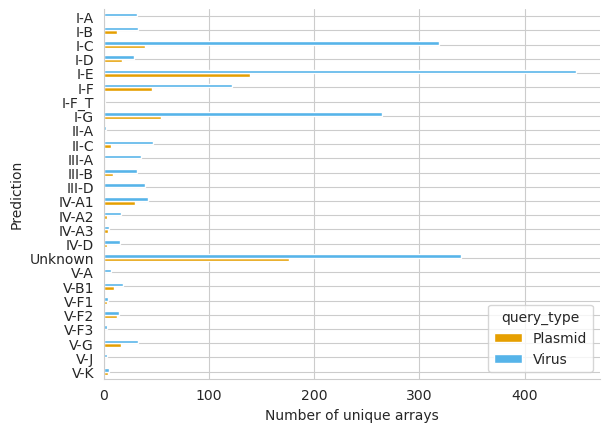

In [112]:
fig, ax = plt.subplots()
final_df[(final_df["hit_type"] == "Host")].drop_duplicates(
    subset=["query_type", "array_name"]
).groupby("query_type")["Prediction"].value_counts().unstack().T.sort_index(
    ascending=False
).plot(kind="barh", ax=ax)
ax.set_xlabel("Number of unique arrays")
sns.despine()
fig.savefig("../../figures/crispr_prediction.pdf", bbox_inches="tight")

In [104]:
num_arrays_hitting_each_plasmid = (
    final_df[final_df["query_type"] == "Plasmid"]
    .drop_duplicates(subset=["query", "array_name", "query_ptu", "hit_ptu"])
    .groupby("query_ptu")
    .size()
)
num_arrays_hitting_each_plasmid_df = pd.DataFrame(
    data=num_arrays_hitting_each_plasmid.value_counts()
).reset_index()
num_arrays_hitting_each_plasmid_df.columns = ["num_arrays", "count"]
num_arrays_hitting_each_plasmid_df = num_arrays_hitting_each_plasmid_df.sort_values(
    by="num_arrays"
)

num_arrays_hitting_each_plasmid_df["bins"] = pd.cut(
    num_arrays_hitting_each_plasmid_df["num_arrays"],
    bins=[1, 2, 5, 10, 15, np.inf],
    right=False,
)
num_arrays_hitting_each_plasmid_df.head()

,num_arrays,count,bins
1,1,68,"[1.0, 2.0)"
0,2,105,"[2.0, 5.0)"
3,3,32,"[2.0, 5.0)"
2,4,44,"[2.0, 5.0)"
7,5,9,"[5.0, 10.0)"


In [ ]:
num_spacers_hitting_each_plasmid = (
    final_df[final_df["query_type"] == "Plasmid"]
    .drop_duplicates(subset=["query", "spacer_hit", "query_ptu", "hit_ptu"])
    .groupby("query")
    .size()
)
num_spacers_hitting_each_plasmid_df = pd.DataFrame(
    data=num_spacers_hitting_each_plasmid.value_counts()
).reset_index()
num_spacers_hitting_each_plasmid_df.columns = ["num_spacers", "count"]
num_spacers_hitting_each_plasmid_df = num_spacers_hitting_each_plasmid_df.sort_values(
    by="num_spacers"
)

num_spacers_hitting_each_plasmid_df["bins"] = pd.cut(
    num_spacers_hitting_each_plasmid_df["num_spacers"],
    bins=[1, 2, 10, 50, 100, np.inf],
    right=False,
)
num_spacers_hitting_each_plasmid_df.head()

,num_spacers,count,bins
2,1,28,"[1.0, 2.0)"
0,2,111,"[2.0, 10.0)"
1,3,37,"[2.0, 10.0)"
3,4,24,"[2.0, 10.0)"
6,5,15,"[2.0, 10.0)"


In [113]:
final_df[final_df["query_type"] == "Plasmid"].drop_duplicates(
    subset=["query", "spacer_hit", "query_ptu", "hit_ptu"]
).groupby("query").size().sort_values(ascending=False).head().index

Index(['3300050028|Ga0495363_000361', '3300048791|Ga0494738_001416',
       '3300056791|Ga0562384_00107', '3300050031|Ga0495400_000431',
       '3300048775|Ga0494743_000197'],
      dtype='object', name='query')

In [114]:
final_df[
    (final_df["query_type"] == "Plasmid")
    & (final_df["query_ptu"] != final_df["hit_ptu"])
].drop_duplicates(subset=["query", "spacer_hit", "query_ptu", "hit_ptu"]).groupby(
    "query"
).size().sort_values(ascending=False)

query
3300048791|Ga0494738_001416     410
3300050028|Ga0495363_000361     342
3300054973|Ga0495425_000714     339
3300056791|Ga0562384_00107      334
3300048775|Ga0494743_000197     332
                               ... 
3300046525|Ga0495663_0000011      1
3300046519|Ga0495632_0000036      1
3300046501|Ga0495607_0000135      1
3300046458|Ga0495591_000075       1
3300047657|Ga0497309_002665       1
Length: 469, dtype: int64

In [115]:
final_df[final_df["query"] == "3300047642|Ga0497317_006002"]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Trusted,Prediction,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction


In [116]:
final_df[final_df["query_type"] == "Plasmid"].drop_duplicates(
    subset=["query", "spacer_hit", "query_ptu", "hit_ptu"]
).groupby("query").size().sort_values(ascending=False).index

Index(['3300050028|Ga0495363_000361', '3300048791|Ga0494738_001416',
       '3300056791|Ga0562384_00107', '3300050031|Ga0495400_000431',
       '3300048775|Ga0494743_000197', '3300049822|Ga0501035_0000190',
       '3300049823|Ga0501044_0000199', '3300049568|Ga0501031_0000020',
       '3300049581|Ga0501047_0000183', '3300054973|Ga0495425_000714',
       ...
       '3300047657|Ga0497309_002665', '3300047673|Ga0495593_0000002',
       'PLSDB_NZ_CP024907.1', 'PLSDB_NZ_CP030772.1',
       '3300036800|Ga0376674_0003534', '3300036795|Ga0376668_0007896',
       '3300044739|Ga0467042_0001200', '3300048775|Ga0494743_011012',
       '3300053171|Ga0494674_000263', '2162886015|FOassembled-_contig00083'],
      dtype='object', name='query', length=512)

In [117]:
final_df[
    (
        final_df["query"].isin(
            final_df[
                (final_df["query_type"] == "Plasmid")
                & (final_df["query_ptu"] != final_df["hit_ptu"])
            ]
            .drop_duplicates(subset=["query", "spacer_hit", "query_ptu", "hit_ptu"])
            .groupby("query")
            .size()
            .sort_values(ascending=False)
            .head()
            .index
        )
        & (final_df["query_ptu"] != final_df["hit_ptu"])
    )
].drop_duplicates(subset=["query_ptu", "hit_ptu"])[
    ["query", "hit_name", "hit_ecosystem", "query_ptu", "hit_ptu", "hit_taxonomy"]
]

,query,hit_name,hit_ecosystem,query_ptu,hit_ptu,hit_taxonomy
844,3300048775|Ga0494743_000197,3300050032|Ga0495410_005119,Peat,PTU-00005,NaN,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
844,3300048775|Ga0494743_000197,3300048791|Ga0494738_001416,Peat,PTU-00005,PTU-03189,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
854,3300048791|Ga0494738_001416,3300056791|Ga0562384_00107,Peat,PTU-03189,PTU-00005,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
854,3300048791|Ga0494738_001416,3300050032|Ga0495410_005119,Peat,PTU-03189,NaN,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1233,3300054973|Ga0495425_000714,3300056870|Ga0562386_15127,Peat,PTU-00012,NaN,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
1233,3300054973|Ga0495425_000714,3300049719|Ga0495414_0000136,Peat,PTU-00012,PTU-00001,d__Bacteria;p__Acidobacteriota;c__Terriglobia;...


NameError: name 'num_spacers_hitting_each_plasmid_df' is not defined

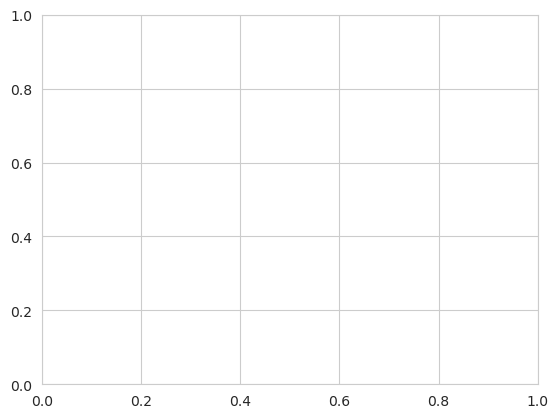

In [118]:
fig, ax = plt.subplots()
sns.barplot(
    x=num_spacers_hitting_each_plasmid_df["bins"],
    y=num_spacers_hitting_each_plasmid_df["count"],
    errorbar=None,
    estimator="sum",
    ax=ax,
    color="steelblue",
)
sns.despine()


# add fraction column to top of the bars
for i in ax.containers:
    print(i.datavalues)
    ax.bar_label(
        i,
        labels=[
            f"{round(j / num_spacers_hitting_each_plasmid_df['count'].sum() * 100, 2)}%"
            for j in i.datavalues
        ],
        label_type="edge",
        fontsize=8,
        padding=3,
    )

ax.set_title("For a given plasmid, how many CRISPR spacers hit it?")
ax.set_xlabel("")
ax.set_xticklabels(["1", "2-9", "10-49", "50-99", "100+"])
ax.set_ylabel("Number of PTUs")

fig.savefig("../figures/num_spacers_hitting_a_plasmid.pdf", bbox_inches="tight")

In [119]:
final_df[
    final_df["query_ptu"].isin(
        num_arrays_hitting_each_plasmid.sort_values(ascending=False).head().index
    )
].groupby("query_ptu")["query_ecosystem"].value_counts()

NameError: name 'num_arrays_hitting_each_plasmid' is not defined

In [120]:
final_df[
    final_df["query_ptu"].isin(
        num_arrays_hitting_each_plasmid.sort_values(ascending=False).head().index
    )
].groupby("query_ptu")["hit_taxonomy"].value_counts()

NameError: name 'num_arrays_hitting_each_plasmid' is not defined

---
## CRISPRS encoded in plasmids

In [121]:
print(
    f"{final_df[final_df['hit_type'] == 'Plasmid']['spacer_hit'].nunique()} unique spacers, from {final_df[final_df['hit_type'] == 'Plasmid']['array_name'].nunique()} unique arrays in {final_df[final_df['hit_type'] == 'Plasmid']['hit_name'].nunique()} unique plasmids ({final_df[final_df['hit_type'] == 'Plasmid']['hit_ptu'].nunique()} PTUs)"
)

2433 unique spacers, from 180 unique arrays in 137 unique plasmids (86 PTUs)


In [122]:
final_df[(final_df["hit_type"] == "Plasmid")].drop_duplicates(
    subset=["query", "spacer_hit"]
)["query_type"].value_counts()

query_type
Plasmid    4492
Virus       401
Name: count, dtype: int64

Is there a difference in quantity of array-carrying PTUs for different ecosystems?

In [123]:
# Show how many samples are contributing to the data
env_samples = (
    final_df.drop_duplicates(subset=["hit_taxon_oid"])["hit_ecosystem"]
    .value_counts()
    .to_dict()
)

In [124]:
final_df.columns

Index(['query', 'spacer_hit', 'hit_name', 'array_name', 'query_taxon_oid',
       'hit_taxon_oid', 'query_ecosystem', 'hit_ecosystem', 'query_ptu',
       'hit_ptu', 'hit_votu', 'checkv', 'query_votu', 'virus_taxonomy',
       'Trusted', 'Prediction', 'Subtype', 'Subtype_probability', 'hit_type',
       'query_type', 'hit_taxonomy', 'contig_type', 'plasmid_host',
       'Simple_prediction'],
      dtype='object')

/tmp/ipykernel_1684048/341983074.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


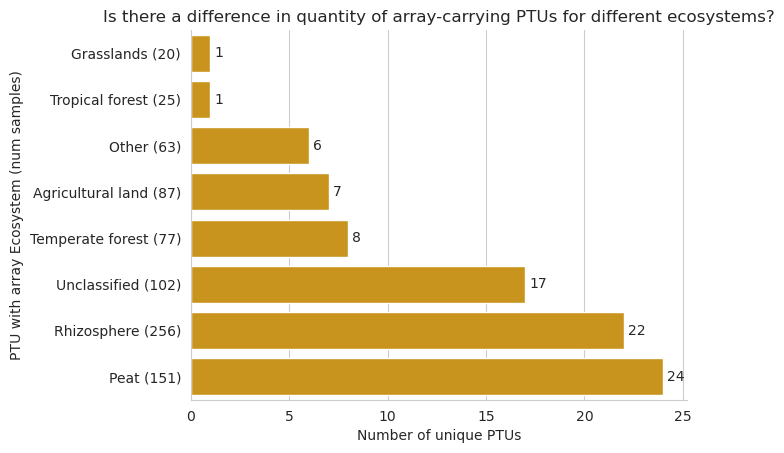

In [125]:
fig, ax = plt.subplots()

sns.barplot(
    final_df[final_df["hit_type"] == "Plasmid"]
    .groupby("hit_ecosystem")["hit_ptu"]
    .nunique()
    .sort_values(),
    orient="h",
    ax=ax,
)

ax.set_yticklabels(
    [
        f"{label.get_text()} ({env_samples[label.get_text()]})"
        for label in ax.get_yticklabels()
    ]
)
for i in ax.containers:
    ax.bar_label(i, padding=3)

ax.set_title(
    "Is there a difference in quantity of array-carrying PTUs for different ecosystems?"
)

ax.set_ylabel("PTU with array Ecosystem (num samples)")
ax.set_xlabel("Number of unique PTUs")
sns.despine()

# fig.savefig("../../figures/num_ptus_carrying_array_ecosystem.pdf", bbox_inches="tight")

Text(0.5, 1.0, 'What are the CRISPR types in plasmids for targeting plasmids/viruses?')

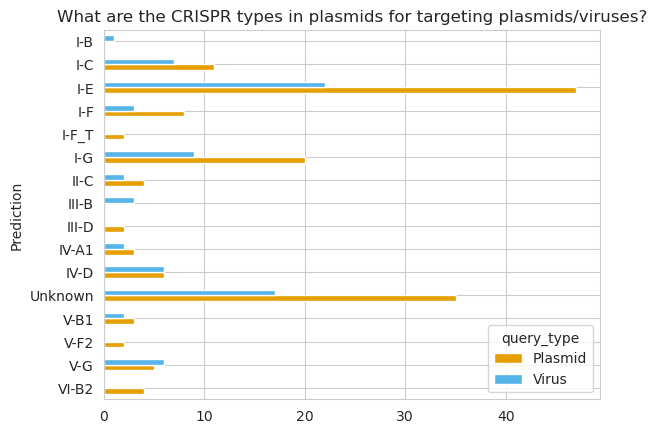

In [126]:
fig, ax = plt.subplots()

final_df[(final_df["hit_type"] == "Plasmid")].drop_duplicates(
    subset=["query_type", "array_name"]
).groupby(["Prediction", "query_type"])["hit_type"].count().unstack().sort_index(
    ascending=False
).plot(kind="barh", ax=ax)

ax.set_title("What are the CRISPR types in plasmids for targeting plasmids/viruses?")

# fig.savefig("../../figures/crispr_types_in_plasmids.pdf", bbox_inches="tight")

In [127]:
df.head()

,query,spacer_hit,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,hit_votu
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,True,False,False,True,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10009382_35:23,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN
2,3300003316|rootH1_10000298,3300003323|rootH1_10001069_28:23,3300003323|rootH1_10001069,3300003323|rootH1_10001069_28,False,False,False,True,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,NaN


In [128]:
# split final_df['hit_taxonomy'] into multiple columns

# Step 1: Split the 'hit_taxonomy' column
split_df = final_df["hit_taxonomy"].str.split(";", expand=True)

# Step 2: Concatenate the original DataFrame with the new DataFrame
final_df = pd.concat(
    [final_df, split_df[[1, 3]].rename(columns={1: "hit_p__", 3: "hit_o__"})], axis=1
)

Any difference in phyla/orders with CRISPR-carrying plasmids vs organisms with CRISPRs in their chromosomes?

In [129]:
final_df[final_df["hit_type"] == "Plasmid"]["hit_p__"].unique()

array(['p__Actinomycetota', 'p__Cyanobacteriota', 'p__Pseudomonadota',
       nan, None, 'p__Myxococcota', 'p__Acidobacteriota',
       'p__Bacteroidota'], dtype=object)

In [130]:
final_df[final_df["hit_type"] == "Host"]["hit_p__"].unique()

array(['p__Actinomycetota', None, 'p__Pseudomonadota', 'p__Bacteroidota',
       'p__Acidobacteriota', 'p__Bacillota', nan, 'p__Cyanobacteriota',
       'p__Myxococcota', 'p__Fibrobacterota', 'p__Desulfobacterota B',
       'p__Planctomycetota', 'p__Chloroflexota', 'p__Verrucomicrobiota',
       'p__Halobacteriota', 'p__Thermoproteota', 'p__Armatimonadota',
       'p__Desulfobacterota', 'p__Nanoarchaeota', 'p__Nitrospirota',
       'p__Methylomirabilota', 'p__Bacillota A', 'p__Spirochaetota',
       'p__Gemmatimonadota', 'p__Bacillota B', 'p__Dormibacterota',
       'p__Caldisericota'], dtype=object)

In [131]:
final_df.groupby("query_ptu")["hit_taxonomy"].unique()

query_ptu
PTU-00001    [d__Bacteria, d__Bacteria;p__Acidobacteriota;c...
PTU-00005    [d__Bacteria;p__Acidobacteriota;c__Terriglobia...
PTU-00006    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
PTU-00012    [d__Bacteria, d__Bacteria;p__Acidobacteriota;c...
PTU-00015                                        [d__Bacteria]
                                   ...                        
PTU-57031    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
PTU-57070    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
PTU-57099    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
PTU-57153    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
PTU-57230    [d__Bacteria;p__Actinomycetota;c__Actinomyceti...
Name: hit_taxonomy, Length: 341, dtype: object

Type IV were found to exhibit a strong bias towards the targeting of other plasmids. Our data indicate that the functions of type IV systems have diverged from those of other host-related CRISPR–Cas immune systems to adopt a role in mediating conflicts between plasmids. Furthermore, we find evidence for cross-talk between certain type IV and type I CRISPR–Cas systems that co-exist intracellularly, thus providing a simple answer to the enigmatic absence of type IV adaptation modules (https://academic.oup.com/nar/article/48/4/2000/5687823?login=false)

In [132]:
final_df[final_df["Prediction"].str.contains("IV")]["query_type"].value_counts()

query_type
Plasmid    13064
Virus        931
Name: count, dtype: int64

In [133]:
final_df[final_df["Prediction"].str.contains("IV")]

,query,spacer_hit,hit_name,array_name,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,...,Subtype,Subtype_probability,hit_type,query_type,hit_taxonomy,contig_type,plasmid_host,Simple_prediction,hit_p__,hit_o__
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown,p__Actinomycetota,o__Streptomycetales
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown,p__Actinomycetota,o__Streptomycetales
2,3300003316|rootH1_10000298,3300003323|rootH1_10019626_29:33,3300003323|rootH1_10019626,3300003323|rootH1_10019626_29,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,IV-A1,0.693,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Unknown,p__Actinomycetota,o__Streptomycetales
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,IV-A1,0.948,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,IV,p__Actinomycetota,o__Streptomycetales
2,3300003316|rootH1_10000298,3300003323|rootH1_10009756_23:13,3300003323|rootH1_10009756,3300003323|rootH1_10009756_23,3300003316,3300003323,Unclassified,Unclassified,PTU-24838,NaN,...,IV-A1,0.948,Host,Plasmid,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,Organism,d__Bacteria;p__Actinomycetota;c__Actinomycetia...,IV,p__Actinomycetota,o__Streptomycetales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9748,3300060779|Ga0597113_0000004|provirus_13435_95399,3300060779|Ga0597113_0000004_7:1,3300060779|Ga0597113_0000004,3300060779|Ga0597113_0000004_7,3300060779,3300060779,Temperate forest,Temperate forest,NaN,NaN,...,IV-A3,0.799,Host,Virus,d__Bacteria,Organism,NaN,IV,None,None
9748,3300060779|Ga0597113_0000004|provirus_13435_95399,3300060779|Ga0597113_0000004_7:1,3300060779|Ga0597113_0000004,3300060779|Ga0597113_0000004_7,3300060779,3300060779,Temperate forest,Temperate forest,NaN,NaN,...,IV-A3,0.990,Host,Virus,d__Bacteria,Organism,NaN,IV,None,None
9748,3300060779|Ga0597113_0000004|provirus_13435_95399,3300060779|Ga0597113_0000004_7:1,3300060779|Ga0597113_0000004,3300060779|Ga0597113_0000004_7,3300060779,3300060779,Temperate forest,Temperate forest,NaN,NaN,...,IV-A3,0.801,Host,Virus,d__Bacteria,Organism,NaN,IV,None,None
9932,MGYA00645541|ERZ12303513.105-NODE-105-length-3...,3300003323|rootH1_10009382_35:56,3300003323|rootH1_10009382,3300003323|rootH1_10009382_35,MGYA00645541,3300003323,Rhizosphere,Unclassified,NaN,NaN,...,IV-A1,0.888,Host,Virus,d__Bacteria,Organism,NaN,IV,None,None


In [134]:
type_4_results = defaultdict(set)
for idx, row in final_df[final_df["Prediction"].str.contains("IV")].iterrows():
    if pd.notna(row["query_ptu"]):
        type_4_results["Plasmid"].add(row["query_ptu"])
    elif pd.notna(row["query_votu"]):
        type_4_results["Virus"].add(row["query_votu"])

for k, v in type_4_results.items():
    print(f"Number of {k} TUs: {len(v)}")

Number of Plasmid TUs: 32
Number of Virus TUs: 91


In [135]:
final_df[
    (final_df["array_name"].isin(arrays_hitting_both))
    & (final_df["hit_type"] == "Plasmid")
    & (final_df["query_type"] == "Virus")
].drop_duplicates(subset=["query"])["hit_taxonomy"].value_counts()

Series([], Name: count, dtype: int64)

In [136]:
final_df[
    (final_df["hit_type"] == "Plasmid") & (final_df["query_type"] == "Virus")
].drop_duplicates(subset=["query"])["hit_taxonomy"]

37       d__Bacteria;p__Actinomycetota;c__Actinomycetia...
80       d__Bacteria;p__Actinomycetota;c__Actinomycetia...
310      d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
320      d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
345      d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
                               ...                        
9577     d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
9595     d__Bacteria;p__Acidobacteriota;c__Terriglobia;...
9765     d__Bacteria;p__Actinomycetota;c__Actinomycetia...
9801        d__Bacteria;p__Actinomycetota;c__Actinomycetia
10250    d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
Name: hit_taxonomy, Length: 211, dtype: object

---
## Plasmids hitting other plasmids

In [137]:
df[(df["hit_is_plasmid"] == True) & (df["query_ptu"] != df["hit_ptu"])].drop_duplicates(
    subset=["query", "hit_name"]
)

,query,spacer_hit,hit_name,array_name,hit_is_plasmid,hit_is_virus,query_is_virus,query_is_plasmid,query_taxon_oid,hit_taxon_oid,query_ecosystem,hit_ecosystem,query_ptu,hit_ptu,hit_votu
1,2162886015|FOassembled-_contig00083,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,True,False,False,True,2162886015,3300053172,Grasslands,Unclassified,PTU-24873,PTU-11843,NaN
21,3300005531|Ga0070738_10001733,3300027965|Ga0209062_1000993_106:1,3300027965|Ga0209062_1000993,3300027965|Ga0209062_1000993_106,True,False,False,True,3300005531,3300027965,Unclassified,Unclassified,PTU-24630,PTU-07769,NaN
25,3300005548|Ga0070665_100000073,3300028379|Ga0268266_10001846_2:18,3300028379|Ga0268266_10001846,3300028379|Ga0268266_10001846_2,True,False,False,True,3300005548,3300028379,Rhizosphere,Rhizosphere,PTU-06101,PTU-32289,NaN
25,3300005548|Ga0070665_100000073,3300028379|Ga0268266_10000717_330:1,3300028379|Ga0268266_10000717,3300028379|Ga0268266_10000717_330,True,False,False,True,3300005548,3300028379,Rhizosphere,Rhizosphere,PTU-06101,PTU-32174,NaN
28,3300005577|Ga0068857_100000035,3300026116|Ga0207674_10000017_2:12,3300026116|Ga0207674_10000017,3300026116|Ga0207674_10000017_2,True,False,False,True,3300005577,3300026116,Rhizosphere,Rhizosphere,PTU-06122,PTU-02482,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,PLSDB_NZ_CP133099.1,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,True,False,False,True,PLSDB_NZ_CP133099.1,3300053172,Unclassified,Unclassified,PTU-44737,PTU-11843,NaN
1935,PLSDB_NZ_CP133099.1,3300049172|Ga0494679_001299_18:14,3300049172|Ga0494679_001299,3300049172|Ga0494679_001299_18,True,False,False,True,PLSDB_NZ_CP133099.1,3300049172,Unclassified,Unclassified,PTU-44737,PTU-04604,NaN
1936,PLSDB_NZ_CP121272.1,3300049172|Ga0494679_001299_18:4,3300049172|Ga0494679_001299,3300049172|Ga0494679_001299_18,True,False,False,True,PLSDB_NZ_CP121272.1,3300049172,Unclassified,Unclassified,PTU-12333,PTU-04604,NaN
1936,PLSDB_NZ_CP121272.1,3300053172|Ga0494669_000275_59:25,3300053172|Ga0494669_000275,3300053172|Ga0494669_000275_59,True,False,False,True,PLSDB_NZ_CP121272.1,3300053172,Unclassified,Unclassified,PTU-12333,PTU-11843,NaN


In [138]:
plasmid_ptu_hits = defaultdict(set)

for _, row in df[
    (df["hit_is_plasmid"] == True) & (df["query_ptu"] != df["hit_ptu"])
].iterrows():
    plasmid_ptu_hits[row["query_ptu"]].add(row["hit_ptu"])

filtered_ptu_hits = {k: [v] for k, v in plasmid_ptu_hits.items() if len(v) > 1}

print(
    f"There are {len(filtered_ptu_hits.keys())} PTUs hitting more than one PTU. They are:\n{'\n'.join(filtered_ptu_hits.keys())}"
)

There are 7 PTUs hitting more than one PTU. They are:
PTU-06101
PTU-57031
PTU-38124
PTU-38149
PTU-44738
PTU-44737
PTU-12333


In [139]:
len(plasmid_ptu_hits.keys())

54

In [148]:
hits = defaultdict(set)
for idx, row in df[
    (df["hit_is_plasmid"] == True) & (df["query_is_plasmid"] == True)
].iterrows():
    if row["query_ptu"] != row["hit_ptu"]:
        hits[row["query_ptu"]].add(row["hit_ptu"])

reciprocal_hits = []
for query_ptu, hits_ptus in hits.items():
    for hit_ptu in hits_ptus:
        if hit_ptu in hits.keys() and query_ptu in hits[hit_ptu]:
            reciprocal_hits.append([query_ptu, hit_ptu])
reciprocal_hits

[['PTU-24630', 'PTU-07769'],
 ['PTU-06101', 'PTU-32174'],
 ['PTU-06101', 'PTU-32289'],
 ['PTU-06122', 'PTU-02482'],
 ['PTU-02482', 'PTU-06122'],
 ['PTU-07769', 'PTU-24630'],
 ['PTU-32174', 'PTU-06101'],
 ['PTU-32289', 'PTU-06101'],
 ['PTU-06858', 'PTU-19352'],
 ['PTU-19352', 'PTU-06858'],
 ['PTU-01206', 'PTU-01750'],
 ['PTU-01750', 'PTU-01206'],
 ['PTU-00001', 'PTU-00012'],
 ['PTU-01692', 'PTU-09997'],
 ['PTU-00005', 'PTU-03189'],
 ['PTU-03189', 'PTU-00005'],
 ['PTU-01063', 'PTU-09874'],
 ['PTU-09874', 'PTU-01063'],
 ['PTU-09997', 'PTU-01692'],
 ['PTU-00012', 'PTU-00001']]

In [149]:
# hits = defaultdict(set)
# for idx, row in df[
#     (df["hit_is_plasmid"] == True) & (df["query_is_plasmid"] == True)
# ].iterrows():
#     if row["query_ptu"] != row["hit_ptu"]:
#         hits[row["query_ptu"]].add(row["hit_ptu"])

# reciprocal_hits = {}
# for query_ptu, hits_ptus in hits.items():
#     for hit_ptu in hits_ptus:
#         if hit_ptu in hits.keys() and query_ptu in hits[hit_ptu]:
#             reciprocal_hits.append([query_ptu, hit_ptu])
# reciprocal_hits

In [150]:
len(reciprocal_hits)

20

In [151]:
hits_plasmid = defaultdict(set)
for idx, row in df[
    (df["hit_is_plasmid"] == True) & (df["query_is_plasmid"] == True)
].iterrows():
    if row["query_ptu"] != row["hit_ptu"]:
        hits_plasmid[row["query"]].add(row["hit_name"])

reciprocal_hits_plasmids = []
for query, hits_names in hits_plasmid.items():
    for hit_name in hits_names:
        if hit_name in hits_plasmid.keys() and query in hits_plasmid[hit_name]:
            reciprocal_hits_plasmids.append([query, hit_name])
reciprocal_hits_plasmids

[['3300005531|Ga0070738_10001733', '3300027965|Ga0209062_1000993'],
 ['3300005548|Ga0070665_100000073', '3300028379|Ga0268266_10000717'],
 ['3300005548|Ga0070665_100000073', '3300028379|Ga0268266_10001846'],
 ['3300005577|Ga0068857_100000035', '3300026116|Ga0207674_10000017'],
 ['3300026116|Ga0207674_10000017', '3300005577|Ga0068857_100000035'],
 ['3300027965|Ga0209062_1000993', '3300005531|Ga0070738_10001733'],
 ['3300028379|Ga0268266_10000717', '3300005548|Ga0070665_100000073'],
 ['3300028379|Ga0268266_10001846', '3300005548|Ga0070665_100000073'],
 ['3300036835|Ga0376027_0000684', '3300037153|Ga0376026_0001227'],
 ['3300037153|Ga0376026_0001227', '3300036835|Ga0376027_0000684'],
 ['3300046642|Ga0495634_0001702', '3300047317|Ga0495604_0019277'],
 ['3300047317|Ga0495604_0019277', '3300046642|Ga0495634_0001702'],
 ['3300048769|Ga0494733_0000079', '3300054973|Ga0495425_000714'],
 ['3300048775|Ga0494743_000228', '3300050028|Ga0495363_002880'],
 ['3300048775|Ga0494743_000197', '3300048791|

In [152]:
len(reciprocal_hits_plasmids)

42

In [90]:
envs = {}
for reciprocal_hit in reciprocal_hits:
    env = (
        df[
            (df["query_ptu"] == reciprocal_hit[0])
            & (df["hit_ptu"] == reciprocal_hit[1])
        ]
        .drop_duplicates(subset=["query", "hit_name"])["query_ecosystem"]
        .unique()[0]
    )
    if env in envs:
        envs[env] += 1
    else:
        envs[env] = 1

print(envs)

{'Unclassified': 8, 'Rhizosphere': 10, 'Agricultural land': 2, 'Peat': 10}


In [ ]:
for reciprocal_hit in reciprocal_hits:
    df[
        (df["query_ptu"] == reciprocal_hit[0]) & (df["hit_ptu"] == reciprocal_hit[1])
    ].drop_duplicates(subset=["query", "hit_name"])["query_name"].unique()

In [ ]:
filtered_ptu_hits_df = (
    pd.DataFrame.from_dict(filtered_ptu_hits, orient="index").explode(0).reset_index()
)

filtered_ptu_hits_df.columns = ["query_ptu", "hit_ptu"]

filtered_ptu_hits_df["query_ptu_env"] = filtered_ptu_hits_df["query_ptu"].apply(
    lambda x: df[df["query_ptu"] == x]["query_ecosystem"].unique()
)

filtered_ptu_hits_df["hit_ptu_env"] = filtered_ptu_hits_df["hit_ptu"].apply(
    lambda x: df[df["hit_ptu"] == x]["hit_ecosystem"].unique()
)

filtered_ptu_hits_df.head()

,query_ptu,hit_ptu,query_ptu_env,hit_ptu_env
0,PTU-06742,PTU-32999,[Rhizosphere],[Rhizosphere]
1,PTU-06742,PTU-32776,[Rhizosphere],[Rhizosphere]
2,PTU-57346,PTU-11621,[Unclassified],[Rhizosphere]
3,PTU-57346,PTU-01051,[Unclassified],[Rhizosphere]
4,PTU-38988,PTU-11621,[Unclassified],[Rhizosphere]


In [ ]:
filtered_ptu_hits_df

,query_ptu,hit_ptu,query_ptu_env,hit_ptu_env
0,PTU-06742,PTU-32999,[Rhizosphere],[Rhizosphere]
1,PTU-06742,PTU-32776,[Rhizosphere],[Rhizosphere]
2,PTU-57346,PTU-11621,[Unclassified],[Rhizosphere]
3,PTU-57346,PTU-01051,[Unclassified],[Rhizosphere]
4,PTU-38988,PTU-11621,[Unclassified],[Rhizosphere]
5,PTU-38988,PTU-01051,[Unclassified],[Rhizosphere]
6,PTU-38942,PTU-11621,[Unclassified],[Rhizosphere]
7,PTU-38942,PTU-01051,[Unclassified],[Rhizosphere]
8,PTU-00507,PTU-57283,[Unclassified],[Unclassified]
9,PTU-00507,PTU-07758,[Unclassified],[Unclassified]


In [ ]:
filtered_ptu_hits_df[
    filtered_ptu_hits_df["query_ptu_env"] != filtered_ptu_hits_df["hit_ptu_env"]
]

,query_ptu,hit_ptu,query_ptu_env,hit_ptu_env
2,PTU-57346,PTU-11621,[Unclassified],[Rhizosphere]
3,PTU-57346,PTU-01051,[Unclassified],[Rhizosphere]
4,PTU-38988,PTU-11621,[Unclassified],[Rhizosphere]
5,PTU-38988,PTU-01051,[Unclassified],[Rhizosphere]
6,PTU-38942,PTU-11621,[Unclassified],[Rhizosphere]
7,PTU-38942,PTU-01051,[Unclassified],[Rhizosphere]


There are 337,991 predicted spacers from the metagenomes

In [ ]:
spacer_contigs = set()
spacer_plasmid_contigs = set()
for idx in df.index:
    spacer_list = df.loc[idx, "spacers"].split(",")
    for spacer in spacer_list:
        spacer = spacer.split("_CRISPR")[0]
        spacer_contigs.add(spacer)
        if spacer != df.loc[idx, "plasmid"] and spacer in plasmids:
            spacer_plasmid_contigs.add(spacer)

print(
    f"There are {len(spacer_contigs)} unique spacer meta contigs with hits to plasmids from which {len(spacer_plasmid_contigs)} are hits to plasmid contigs"
)

There are 1128 unique spacer meta contigs with hits to plasmids from which 200 are hits to plasmid contigs
